## **DEMAND FORECASTING FOR E-COMMERCE**

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pmdarima as pm
import pandas as pd
# Load datasets
product_a_df = pd.read_excel('ProductA.xlsx')
product_a_google_clicks_df = pd.read_excel('ProductA_google_clicks.xlsx')
product_a_fb_impressions_df = pd.read_excel('ProductA_fb_impressions.xlsx')

## **Merging the datasets**

In [4]:
# Merge datasets based on 'Day Index'
merged_df = pd.merge(product_a_df, product_a_google_clicks_df, on='Day Index', how="left")
merged_df = pd.merge(merged_df, product_a_fb_impressions_df, on='Day Index', how="left")

# First rows of the merged dataframe
print(merged_df.head())

   Day Index  Quantity  Clicks  Impressions
0 2021-12-01        14     445          620
1 2021-12-02        10     433          890
2 2021-12-03        13     424          851
3 2021-12-04        22     427          881
4 2021-12-05        33     451          678


'**merged_df**' is the merged DataFrame

In [5]:
# print number of rows and columns
rows, columns = merged_df.shape
print(f"Total number of rows: {rows}")
print(f"Total number of columns: {columns}")


Total number of rows: 212
Total number of columns: 4


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [7]:
#View the first few rows of the dataset to understand its structure
print(merged_df.head())

   Day Index  Quantity  Clicks  Impressions
0 2021-12-01        14     445          620
1 2021-12-02        10     433          890
2 2021-12-03        13     424          851
3 2021-12-04        22     427          881
4 2021-12-05        33     451          678


## **Missing value analysis**

In [8]:
# Missing value analysis
print(merged_df.isnull().sum())

Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64


There are no missing values.

## **Outlier Detection**

In [9]:
# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


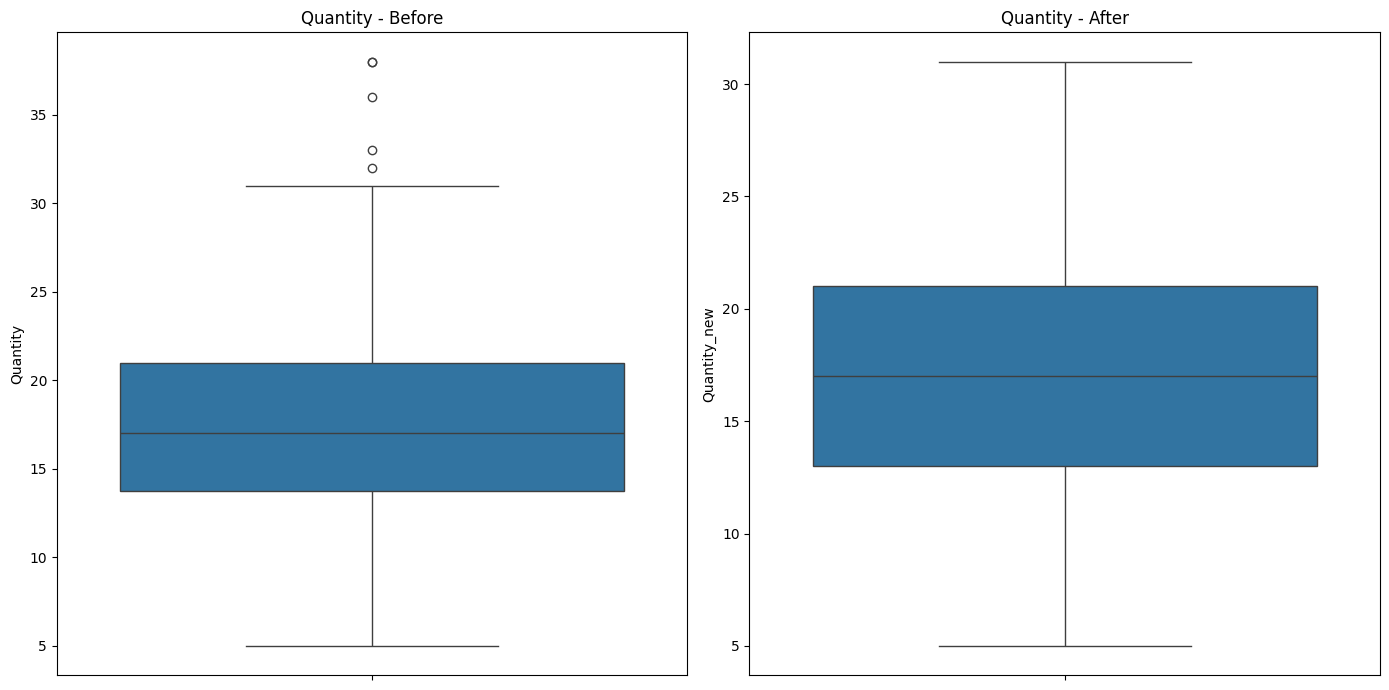

In [10]:
# Removing outliers for Quantity
merged_df['Quantity_new'] = remove_outliers_iqr(merged_df, 'Quantity')['Quantity']

# Plotting box plots before and after outlier removal
plt.figure(figsize=(14, 7))

# Box plot before outlier removal
plt.subplot(1, 2, 1)
sns.boxplot(y=merged_df['Quantity'])
plt.title('Quantity - Before')

# Box plot after outlier removal
plt.subplot(1, 2, 2)
sns.boxplot(y=merged_df['Quantity_new'].dropna())
plt.title('Quantity - After')

plt.tight_layout()
plt.show()

Since outliers were detected in the Quantity data, we removed them using the IQR-based method and named the new column as **Quantity_new**.

In [11]:
# 'merged_df' is the merged DataFrame
rows, columns = merged_df.shape
print(f"Total number of rows: {rows}")
print(f"Total number of columns: {columns}")

Total number of rows: 212
Total number of columns: 5


In [12]:
# Define function to cap outliers based on percentiles for numeric columns
def cap_outliers_percentile(df, column, lower_percentile=5, upper_percentile=95):
    if df[column].dtype in ['int64', 'float64']:  # Check if column is numeric
        lower_bound = df[column].quantile(lower_percentile / 100)
        upper_bound = df[column].quantile(upper_percentile / 100)
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Copy Quantity to Quantity_new
merged_df['Quantity_new'] = merged_df['Quantity']

# Cap outliers for Quantity, Clicks, and Impressions
for col in ['Quantity', 'Clicks', 'Impressions']:
    merged_df = cap_outliers_percentile(merged_df, col)

# Ensure Quantity_new is copied correctly
merged_df['Quantity_new'] = merged_df['Quantity']

# Display the final DataFrame
print(merged_df)

     Day Index  Quantity  Clicks  Impressions  Quantity_new
0   2021-12-01     14.00  445.00        883.2         14.00
1   2021-12-02     10.00  433.00        890.0         10.00
2   2021-12-03     13.00  424.00        883.2         13.00
3   2021-12-04     22.00  427.00        883.2         22.00
4   2021-12-05     27.45  451.00        883.2         27.45
..         ...       ...     ...          ...           ...
207 2022-06-26     13.00  114.00       1218.0         13.00
208 2022-06-27     16.00  110.55       1311.0         16.00
209 2022-06-28     13.00  110.55        885.0         13.00
210 2022-06-29     16.00  110.55       1000.0         16.00
211 2022-06-30      9.00  110.55        883.2          9.00

[212 rows x 5 columns]


## **Feature Engineering**

In [13]:
print(merged_df)

     Day Index  Quantity  Clicks  Impressions  Quantity_new
0   2021-12-01     14.00  445.00        883.2         14.00
1   2021-12-02     10.00  433.00        890.0         10.00
2   2021-12-03     13.00  424.00        883.2         13.00
3   2021-12-04     22.00  427.00        883.2         22.00
4   2021-12-05     27.45  451.00        883.2         27.45
..         ...       ...     ...          ...           ...
207 2022-06-26     13.00  114.00       1218.0         13.00
208 2022-06-27     16.00  110.55       1311.0         16.00
209 2022-06-28     13.00  110.55        885.0         13.00
210 2022-06-29     16.00  110.55       1000.0         16.00
211 2022-06-30      9.00  110.55        883.2          9.00

[212 rows x 5 columns]


In [14]:
# Create the DataFrame
df = pd.DataFrame({'Date': pd.date_range(start='2021-12-01', end='2022-06-30', freq='D')})

# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract basic date components
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day of Week'] = df['Date'].dt.dayofweek
df['Day of Year'] = df['Date'].dt.dayofyear
df['Week of Year'] = df['Date'].dt.isocalendar().week

# One-hot encode the month
df = pd.concat([df, pd.get_dummies(df['Month'], prefix='Month')], axis=1)

# Convert month one-hot encoded columns from boolean to integers
month_columns = [col for col in df.columns if col.startswith('Month_')]
df[month_columns] = df[month_columns].astype(int)

# Encode day of the week as cyclical features
df['Day of Week Sin'] = np.sin(2 * np.pi * df['Day of Week'] / 7)
df['Day of Week Cos'] = np.cos(2 * np.pi * df['Day of Week'] / 7)

# Add features for holidays or special events
us_holidays = holidays.US()
df['Is Holiday'] = df['Date'].apply(lambda x: 1 if x in us_holidays else 0)

# Add seasonality features and convert to 0/1
df['Is Month Start'] = df['Date'].dt.is_month_start.astype(int)
df['Is Month End'] = df['Date'].dt.is_month_end.astype(int)
df['Is Quarter Start'] = df['Date'].dt.is_quarter_start.astype(int)
df['Is Quarter End'] = df['Date'].dt.is_quarter_end.astype(int)
df['Is Year Start'] = df['Date'].dt.is_year_start.astype(int)
df['Is Year End'] = df['Date'].dt.is_year_end.astype(int)

# Handle NaN values
df.fillna(0, inplace=True)  # Fill NaNs with 0

# Display the DataFrame with new features
print(df.head())


        Date  Day  Month  Year  Day of Week  Day of Year  Week of Year  \
0 2021-12-01    1     12  2021            2          335            48   
1 2021-12-02    2     12  2021            3          336            48   
2 2021-12-03    3     12  2021            4          337            48   
3 2021-12-04    4     12  2021            5          338            48   
4 2021-12-05    5     12  2021            6          339            48   

   Month_1  Month_2  Month_3  ...  Month_12  Day of Week Sin  Day of Week Cos  \
0        0        0        0  ...         1         0.974928        -0.222521   
1        0        0        0  ...         1         0.433884        -0.900969   
2        0        0        0  ...         1        -0.433884        -0.900969   
3        0        0        0  ...         1        -0.974928        -0.222521   
4        0        0        0  ...         1        -0.781831         0.623490   

   Is Holiday  Is Month Start  Is Month End  Is Quarter Start  Is Qu

### **Visualisation**

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


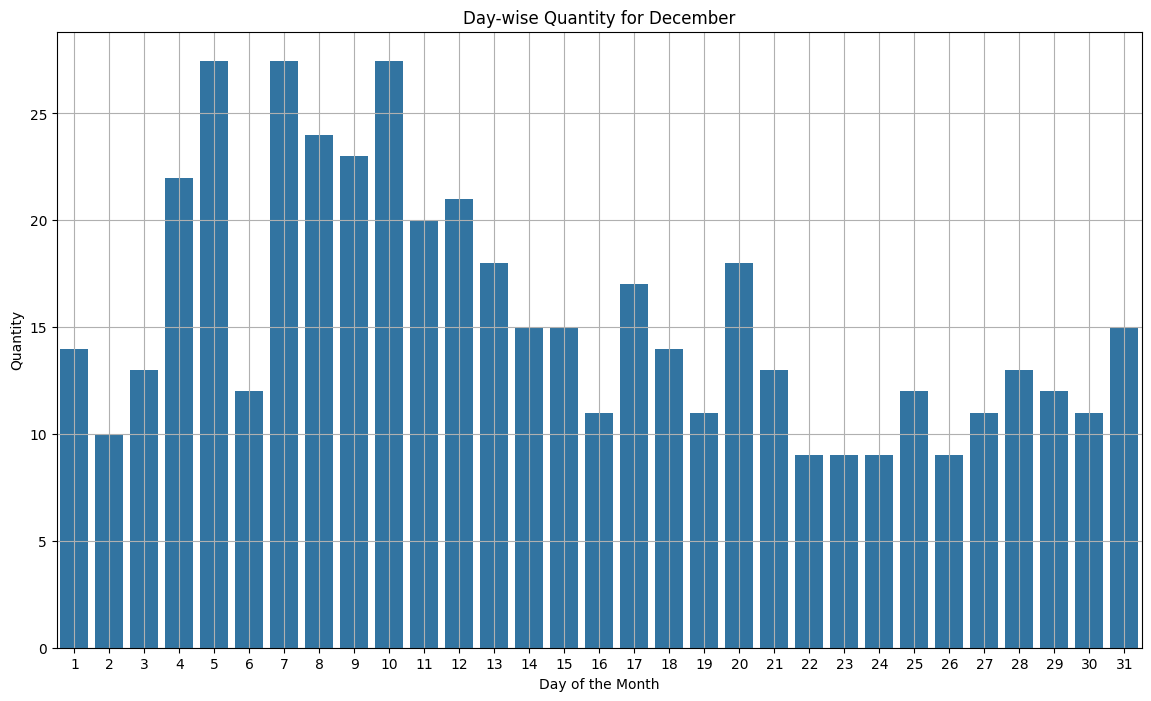

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


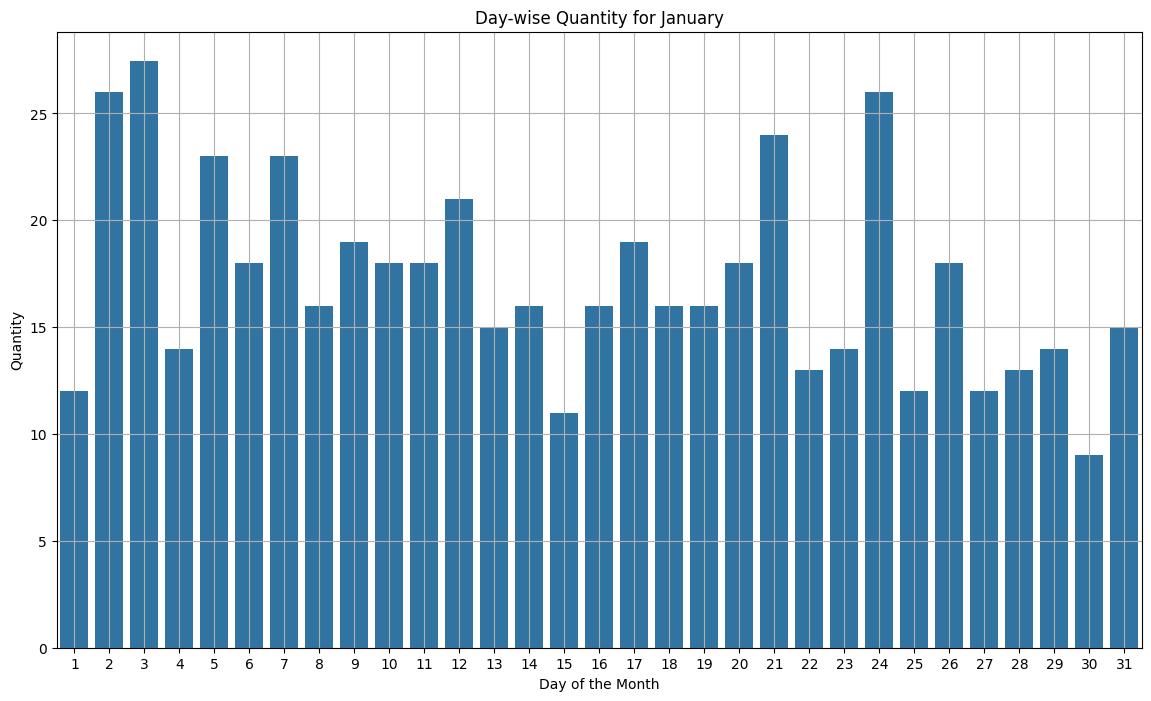

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


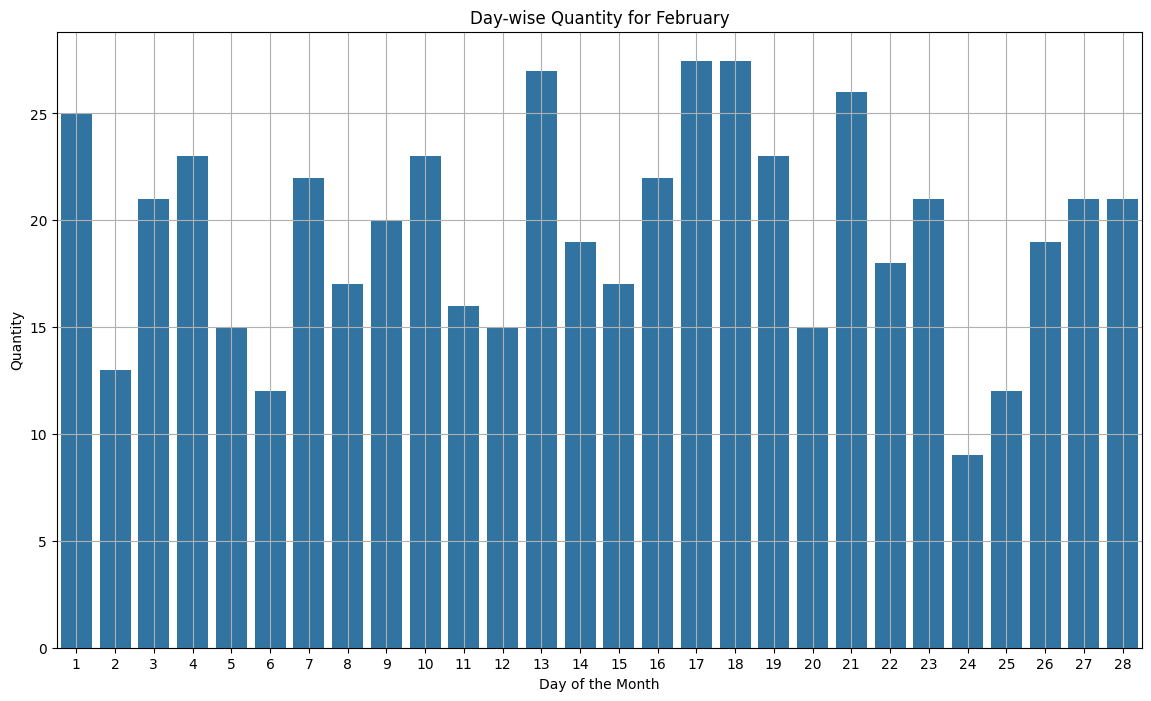

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


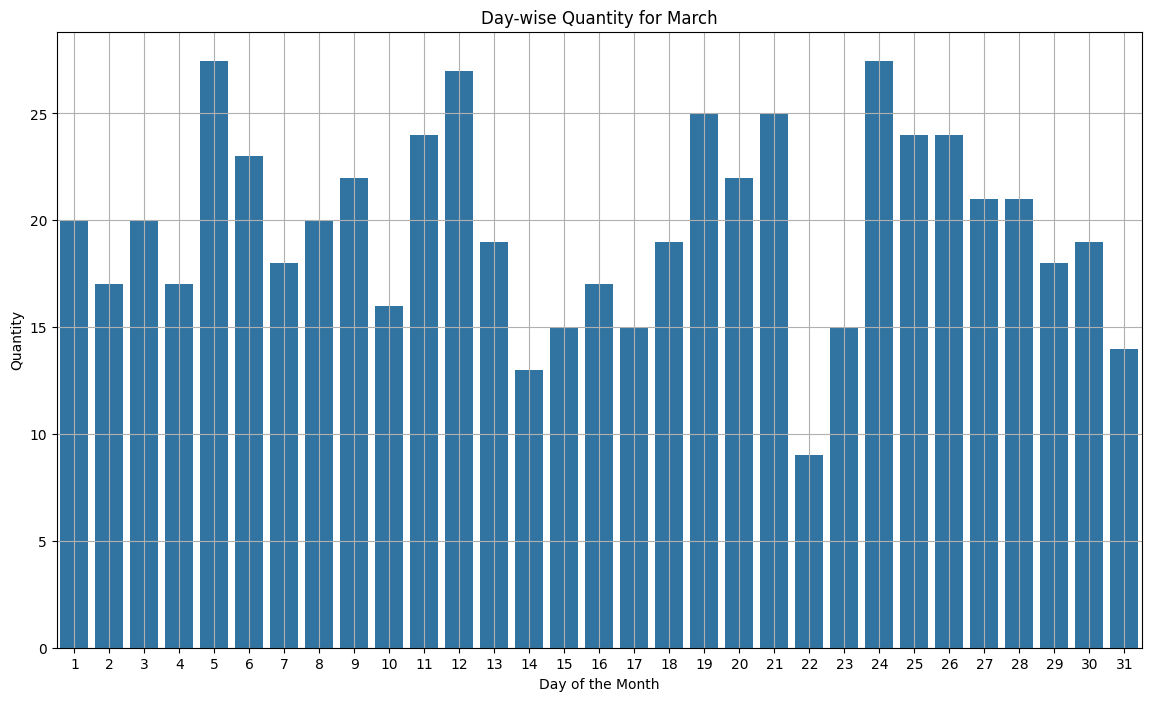

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


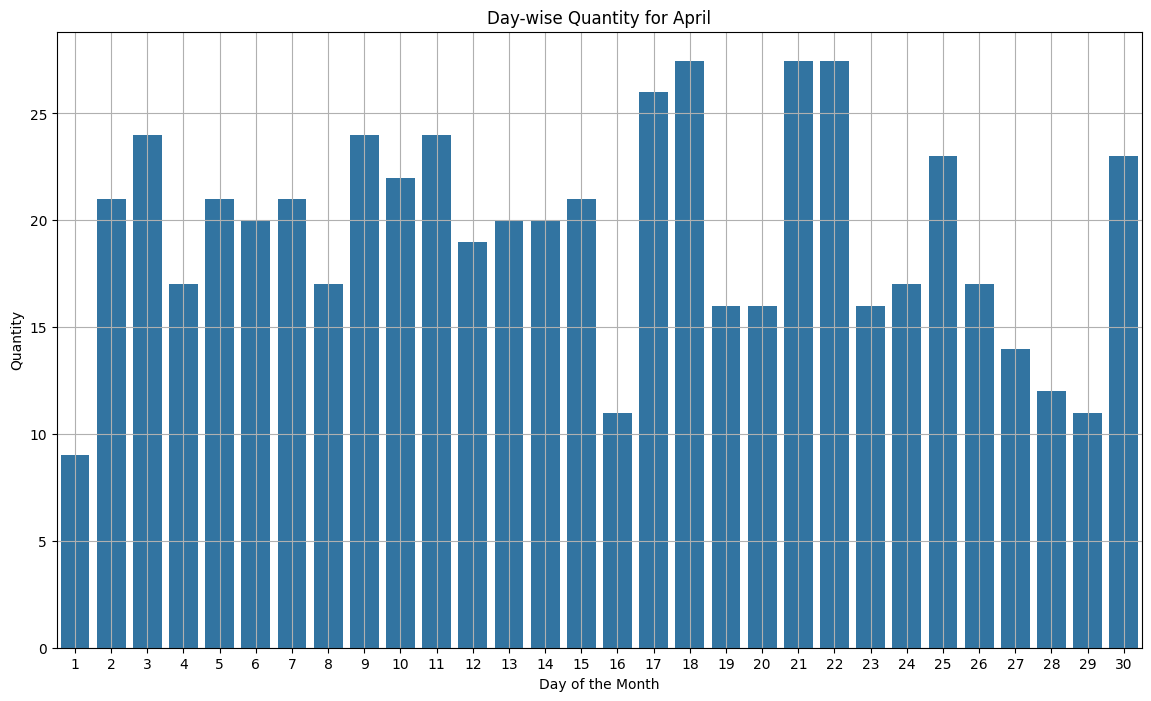

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


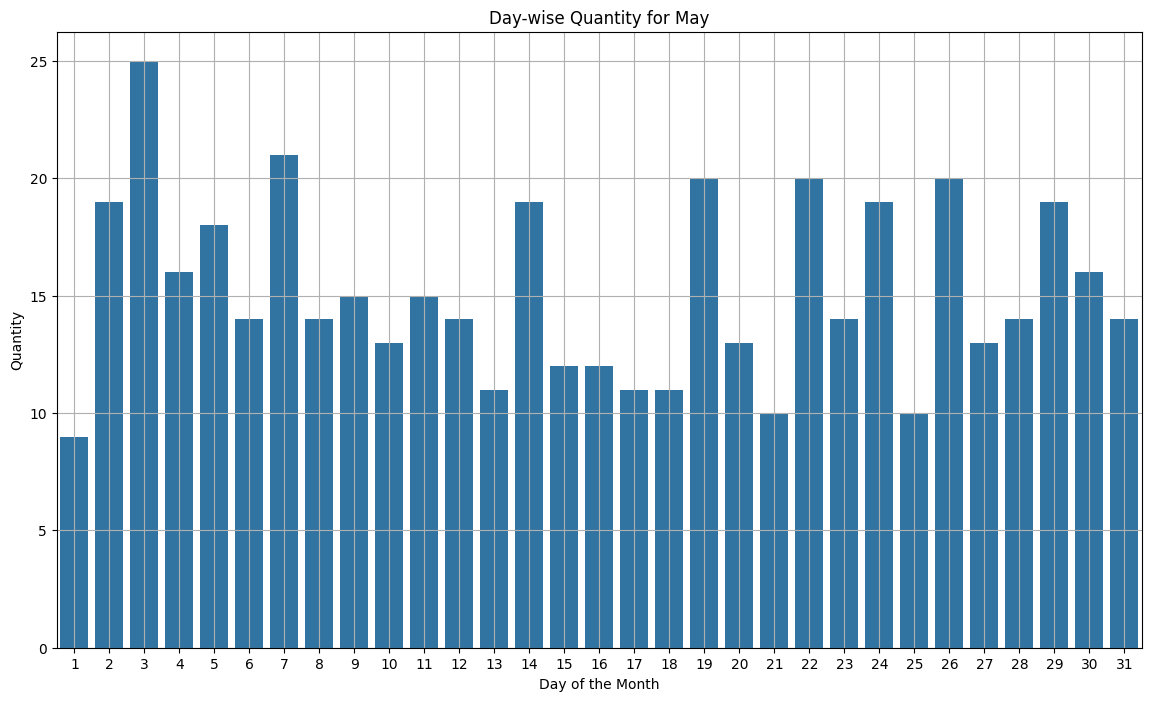

<ipython-input-15-2f1a14952d88>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)


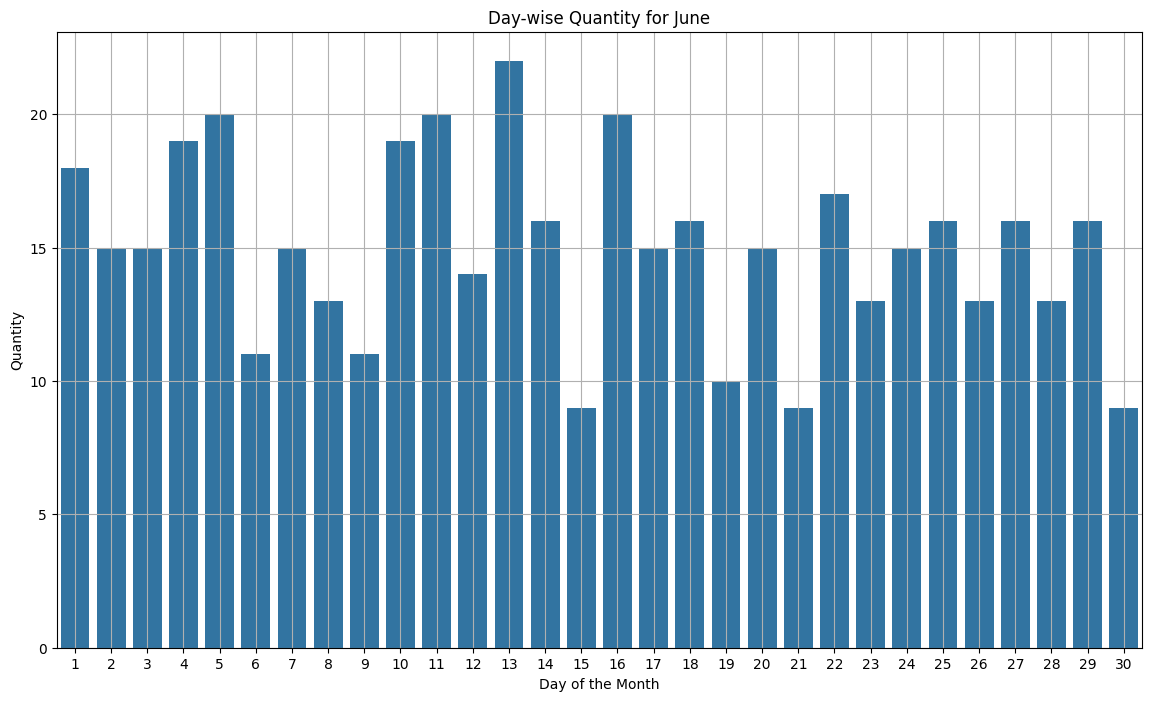

In [15]:
# Ensure the date column is in datetime format
merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

# Extract day and month from the date column
merged_df['Day'] = merged_df['Day Index'].dt.day
merged_df['Month'] = merged_df['Day Index'].dt.month_name()

# List of unique months in the dataset
months = merged_df['Month'].unique()

# Plotting day-wise quantity for each month individually using bar plot
for month in months:
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Day', y='Quantity_new', data=merged_df[merged_df['Month'] == month], ci=None)
    plt.title(f'Day-wise Quantity for {month}')
    plt.xlabel('Day of the Month')
    plt.ylabel('Quantity')
    plt.grid(True)
    plt.show()




*  In the months of **February, March** the sales reached/exceeded 25 for 5 days.
*   In the month of **June** the sales didnt reach 25 on any day of the month.


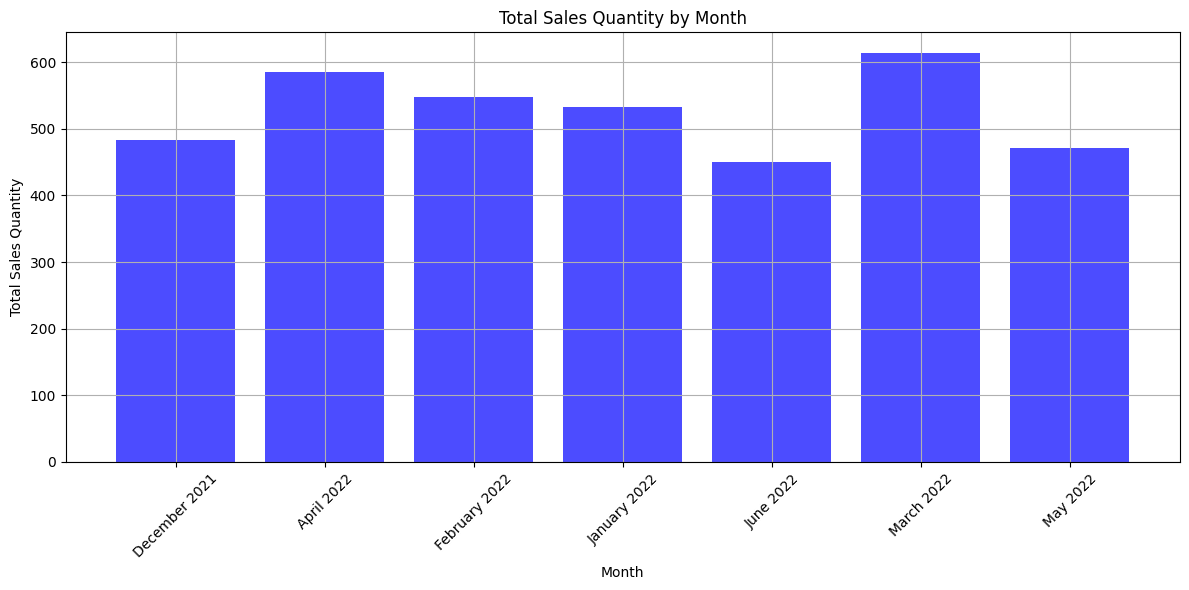

In [16]:
# Ensure the date column is in datetime format
merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

# Extract month and year from 'Day Index'
merged_df['Month'] = merged_df['Day Index'].dt.month
merged_df['Year'] = merged_df['Day Index'].dt.year

# Mapping dictionary for month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Apply month names to the DataFrame
merged_df['Month'] = merged_df['Month'].map(month_names)

# Group by month and year and sum the 'Quantity'
monthly_sales = merged_df.groupby(['Year', 'Month'])['Quantity'].sum()

# Convert groupby object back to DataFrame
monthly_sales = monthly_sales.reset_index()

# Plotting total sales in each month
plt.figure(figsize=(12, 6))
plt.bar(range(len(monthly_sales)), monthly_sales['Quantity'], color='b', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Total Sales Quantity')
plt.title('Total Sales Quantity by Month')
plt.xticks(range(len(monthly_sales)), labels=[f"{row['Month']} {row['Year']}" for _, row in monthly_sales.iterrows()], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


*   March 2022 recorded the highest number of sales
*   June 2022 recorded the least number of sales

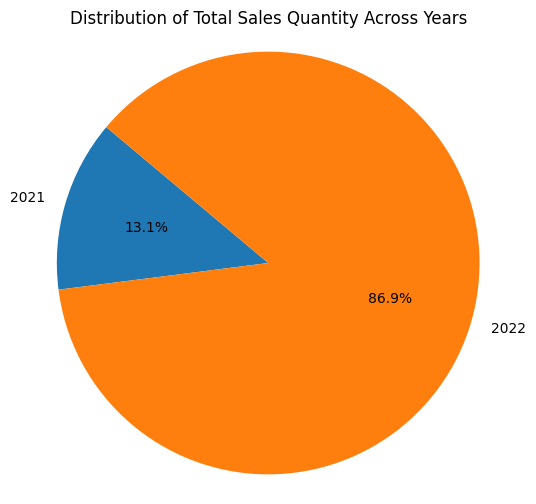

In [17]:
# Ensure the date column is in datetime format
merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

# Extract year from 'Day Index'
merged_df['Year'] = merged_df['Day Index'].dt.year

# Group by year and sum the 'Quantity'
yearly_sales = merged_df.groupby('Year')['Quantity'].sum().reset_index()

# Plotting total sales with a pie chart
plt.figure(figsize=(6, 6))
plt.pie(yearly_sales['Quantity'], labels=yearly_sales['Year'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Total Sales Quantity Across Years')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




* We only have a total of **8** month data.
*  **2021** is recorded less percentage because it have only **1** month of data(i.e December).
*  **2022** have data of **7** months(i.e January to June).





## Linear Regression

Index(['Day Index', 'Quantity'], dtype='object')


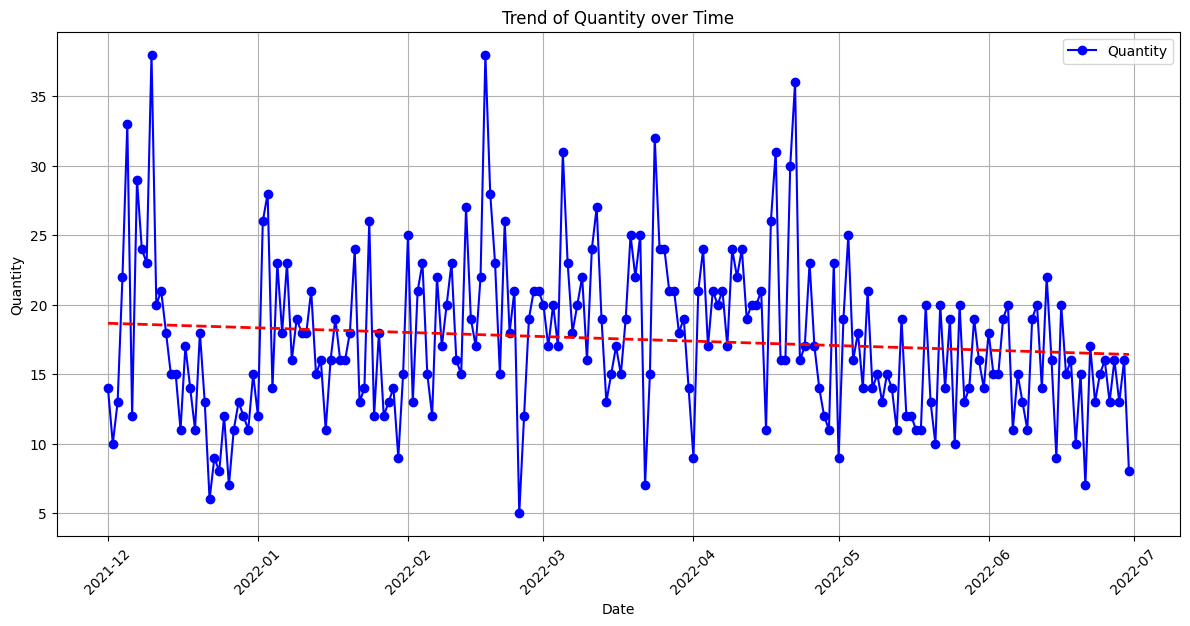

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.700
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.102
Time:                        11:54:45   Log-Likelihood:                -671.28
No. Observations:                 212   AIC:                             1347.
Df Residuals:                     210   BIC:                             1353.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6645      0.789     23.644      0.0

In [18]:
# Check column names in product_a_df
print(product_a_df.columns)

# Assuming 'product_a_df' is already defined and contains your data
plt.figure(figsize=(12, 6))
plt.plot(product_a_df['Day Index'], product_a_df['Quantity'], marker='o', linestyle='-', color='b', label='Quantity')
plt.title('Trend of Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

# Perform linear regression using statsmodels
X = sm.add_constant(range(len(product_a_df)))  # Adding a constant for intercept
y = product_a_df['Quantity']

model = sm.OLS(y, X)
results = model.fit()

# Plotting the regression line
plt.plot(product_a_df['Day Index'], results.predict(X), color='red', linestyle='--', linewidth=2, label='Linear Regression')

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Print regression summary
print(results.summary())



*   This shows a relatively stable pattern. The red dashed line (trend line) shows a slight decline. This implies that the quantity has remained fairly consistent but shows a minor decreasing trend.



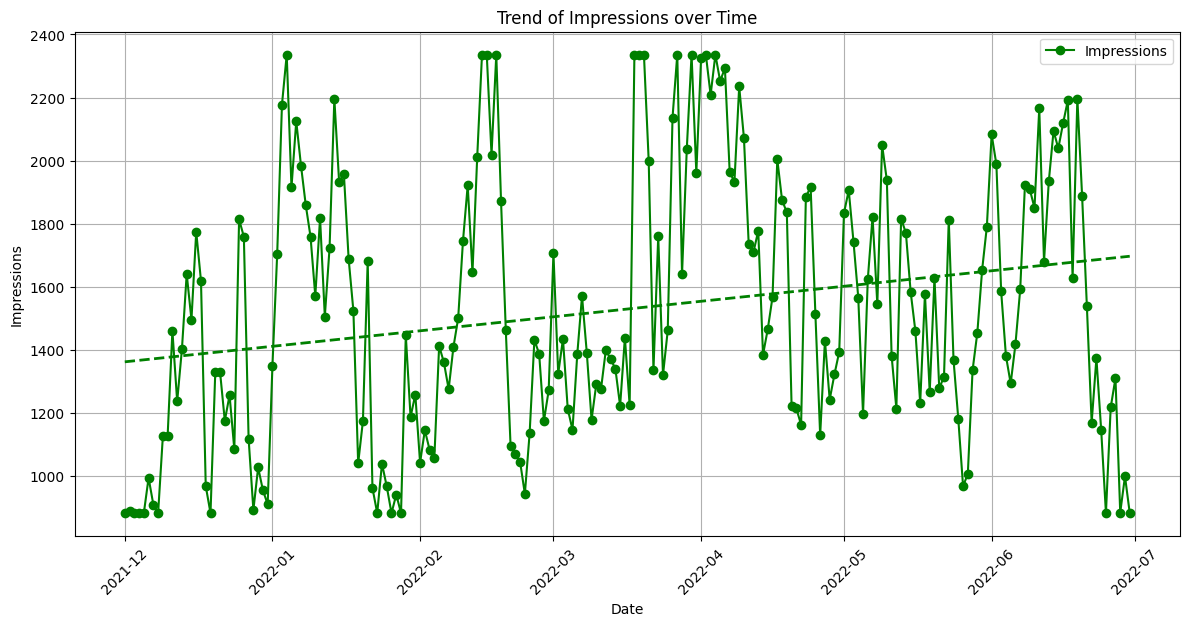

Impressions Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            Impressions   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     11.97
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           0.000656
Time:                        11:54:49   Log-Likelihood:                -1574.4
No. Observations:                 212   AIC:                             3153.
Df Residuals:                     210   BIC:                             3159.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1362.608

In [19]:
# Ensure the date column is in datetime format
merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

plt.figure(figsize=(12, 6))

# Plot Impressions over time
plt.plot(merged_df['Day Index'], merged_df['Impressions'], marker='o', linestyle='-', color='g', label='Impressions')

plt.title('Trend of Impressions over Time')
plt.xlabel('Date')
plt.ylabel('Impressions')
plt.grid(True)
plt.legend()

# Perform linear regression for Impressions using statsmodels
X_impressions = sm.add_constant(range(len(merged_df)))  # Adding a constant for intercept
y_impressions = merged_df['Impressions']
model_impressions = sm.OLS(y_impressions, X_impressions)
results_impressions = model_impressions.fit()
plt.plot(merged_df['Day Index'], results_impressions.predict(X_impressions), color='green', linestyle='--', linewidth=2, label='Impressions Regression')

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Print regression summary for Impressions
print("Impressions Regression Summary:")
print(results_impressions.summary())


*   This shows a slight increase overall. The green dashed line (trend line) indicates an upward trend.
*   This indicates that the number of impressions has been gradually increasing over the observed period.

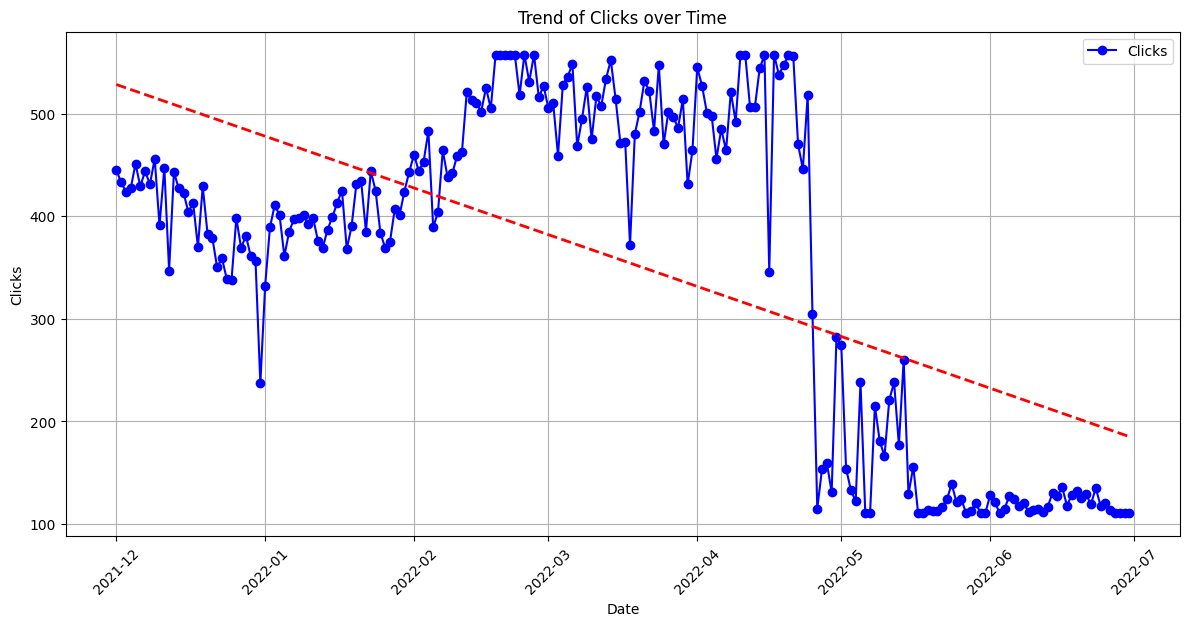

Clicks Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                 Clicks   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     134.3
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           2.50e-24
Time:                        11:54:52   Log-Likelihood:                -1323.5
No. Observations:                 212   AIC:                             2651.
Df Residuals:                     210   BIC:                             2658.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        528.3152    

In [20]:
# Ensure the date column is in datetime format
merged_df['Day Index'] = pd.to_datetime(merged_df['Day Index'])

plt.figure(figsize=(12, 6))

# Plot Clicks over time
plt.plot(merged_df['Day Index'], merged_df['Clicks'], marker='o', linestyle='-', color='b', label='Clicks')

plt.title('Trend of Clicks over Time')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.grid(True)
plt.legend()

# Perform linear regression for Clicks using statsmodels
X_clicks = sm.add_constant(range(len(merged_df)))  # Adding a constant for intercept
y_clicks = merged_df['Clicks']
model_clicks = sm.OLS(y_clicks, X_clicks)
results_clicks = model_clicks.fit()
plt.plot(merged_df['Day Index'], results_clicks.predict(X_clicks), color='red', linestyle='--', linewidth=2, label='Clicks Regression')

plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Print regression summary for Clicks
print("Clicks Regression Summary:")
print(results_clicks.summary())




*   This graph show a noticeable decline. The red dashed line (trend line) indicates a downward trend. This suggests that the number of clicks has been decreasing over the observed period.



                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     5.639
Date:                Mon, 15 Jul 2024   Prob (F-statistic):             0.0185
Time:                        11:54:52   Log-Likelihood:                -640.39
No. Observations:                 212   AIC:                             1285.
Df Residuals:                     210   BIC:                             1291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.3906      1.300     11.073      

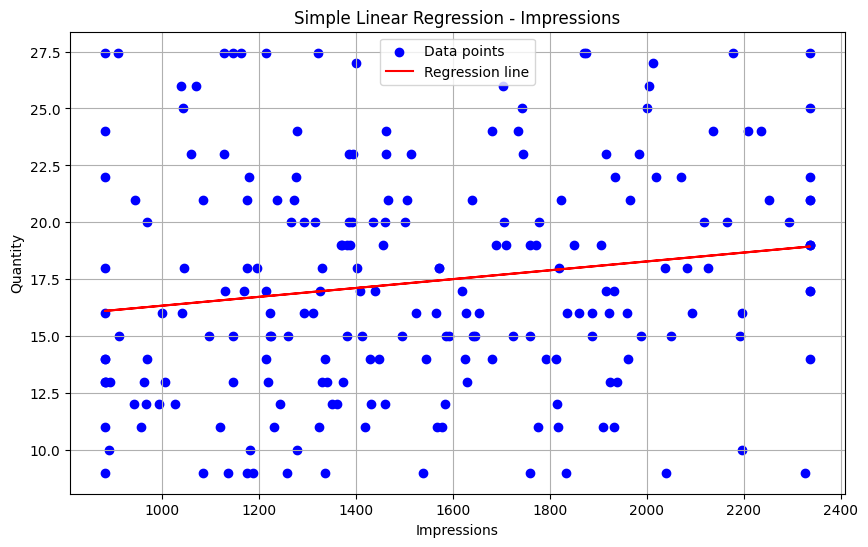

Coefficients: [0.         0.00194596]
Intercept: 14.390640451631327
Mean Squared Error: 24.619849258200915
R-squared: 0.026151020499639466


In [21]:
# Fit linear regression using statsmodels
X = sm.add_constant(merged_df['Impressions'])  # Add constant term to the predictor
y = merged_df['Quantity']  # Define the response variable
model_sm = sm.OLS(y, X).fit()  # Fit the model

# Print regression summary
print(model_sm.summary())

# Plotting the data points and regression line
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Impressions'], merged_df['Quantity_new'], color='blue', label='Data points')  # Plot data points
plt.plot(merged_df['Impressions'], model_sm.predict(X), color='red', label='Regression line')  # Plot regression line
plt.title('Simple Linear Regression - Impressions')
plt.xlabel('Impressions')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Fit linear regression using sklearn (optional)
model_sklearn = LinearRegression()
model_sklearn.fit(X, y)  # Fit the model

# Print coefficients and intercept
print('Coefficients:', model_sklearn.coef_)
print('Intercept:', model_sklearn.intercept_)

# Make predictions
y_pred = model_sklearn.predict(X)

# Evaluate model
mse = mean_squared_error(y, y_pred)  # Calculate Mean Squared Error
r2 = r2_score(y, y_pred)  # Calculate R-squared
print('Mean Squared Error:', mse)
print('R-squared:', r2)




*   This shows that there is a positive correlation between quantity and impressions.



                            OLS Regression Results                            
Dep. Variable:           Quantity_new   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     39.46
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           1.90e-09
Time:                        11:54:54   Log-Likelihood:                -624.95
No. Observations:                 212   AIC:                             1254.
Df Residuals:                     210   BIC:                             1261.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8915      0.780     16.517      0.0

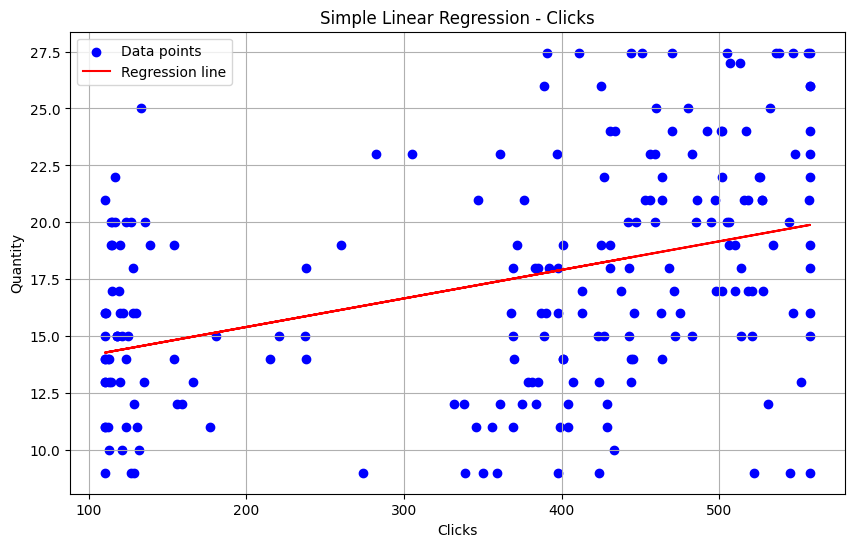

Coefficients: [0.         0.01254766]
Intercept: 12.89148719134879
Mean Squared Error: 21.28236686265295
R-squared: 0.1581666064164443


In [22]:
# Fit linear regression using statsmodels
X = sm.add_constant(merged_df['Clicks'])
y = merged_df['Quantity_new']
model_sm = sm.OLS(y, X).fit()

# Print regression summary
print(model_sm.summary())

# Plotting the data points and regression line
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Clicks'], merged_df['Quantity_new'], color='blue', label='Data points')
plt.plot(merged_df['Clicks'], model_sm.predict(X), color='red', label='Regression line')
plt.title('Simple Linear Regression - Clicks')
plt.xlabel('Clicks')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Fit linear regression using sklearn (optional)
model_sklearn = LinearRegression()
model_sklearn.fit(X, y)

# Print coefficients and intercept
print('Coefficients:', model_sklearn.coef_)
print('Intercept:', model_sklearn.intercept_)

# Make predictions
y_pred = model_sklearn.predict(X)

# Evaluate model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print('Mean Squared Error:', mse)
print('R-squared:', r2)




*  The linear regression line indicates a slight upward trend between clicks and quantity.



## **Correlation Matrix**

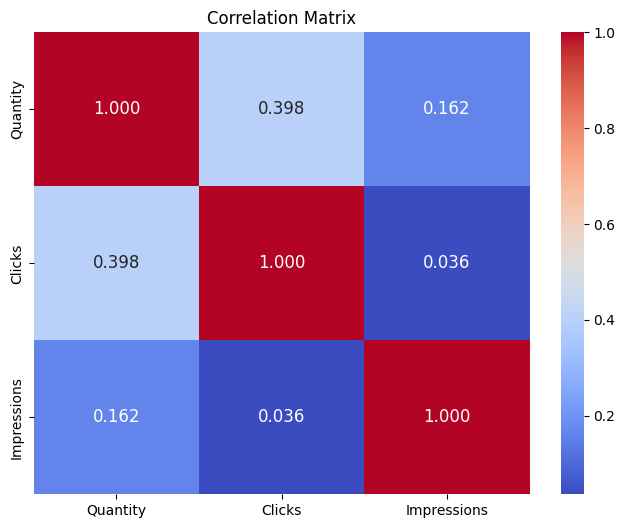

In [23]:
# Calculate correlation matrix
corr_matrix = merged_df[['Quantity', 'Clicks', 'Impressions']].corr()

# Plotting the correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.show()



*   Quantity and clicks have a moderate positive correlation (0.376), while impressions show weak correlation with both quantity and clicks.



## **Time Series Analysis**

## **Stationarity**

In [24]:
#ADF Test
def adf_test(series):
    # Drop NaN values if any
    series = series.dropna()

    # Replace inf values with NaN and drop them
    series.replace([np.inf, -np.inf], np.nan, inplace=True)
    series = series.dropna()

    # Perform ADF test
    result = adfuller(series)

    # Print results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Example usage for stationarity tests
print("Sales Data Stationarity Test:")
adf_test(merged_df['Quantity'])

print("\nGoogle Clicks Data Stationarity Test:")
adf_test(merged_df['Clicks'])

print("\nFacebook Impressions Data Stationarity Test:")
adf_test(merged_df['Impressions'])

Sales Data Stationarity Test:
ADF Statistic: -4.38136267718664
p-value: 0.0003202060264182779
Critical Values:
	1%: -3.4621857592784546
	5%: -2.875537986778846
	10%: -2.574231080806213

Google Clicks Data Stationarity Test:
ADF Statistic: -0.9476524347180738
p-value: 0.7718752186582545
Critical Values:
	1%: -3.4620315036789666
	5%: -2.8754705024827127
	10%: -2.5741950726860647

Facebook Impressions Data Stationarity Test:
ADF Statistic: -5.4919112892132675
p-value: 2.1657414966741358e-06
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557




*   Sales Data: Stationary
*   Google Clicks Data: Non-stationary

*   Facebook Impressions Data: Stationary




## **Trend**

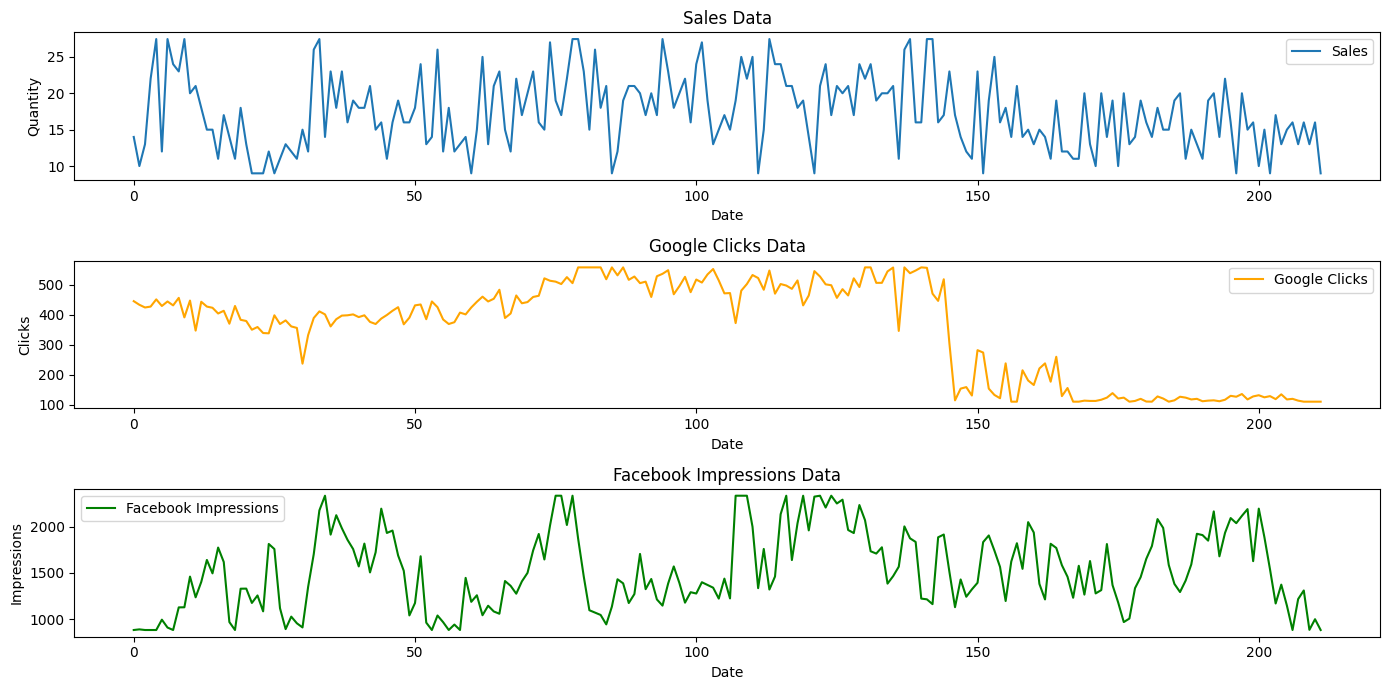

In [25]:
# Plot the time series data
plt.figure(figsize=(14, 7))

# Sales
plt.subplot(3, 1, 1)
plt.plot(merged_df.index, merged_df['Quantity'], label='Sales')
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

# Google Clicks
plt.subplot(3, 1, 2)
plt.plot(merged_df.index, merged_df['Clicks'], label='Google Clicks', color='orange')
plt.title('Google Clicks Data')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()

# Facebook Impressions
plt.subplot(3, 1, 3)
plt.plot(merged_df.index, merged_df['Impressions'], label='Facebook Impressions', color='green')
plt.title('Facebook Impressions Data')
plt.xlabel('Date')
plt.ylabel('Impressions')
plt.legend()

plt.tight_layout()
plt.show()

## **Seasonality**

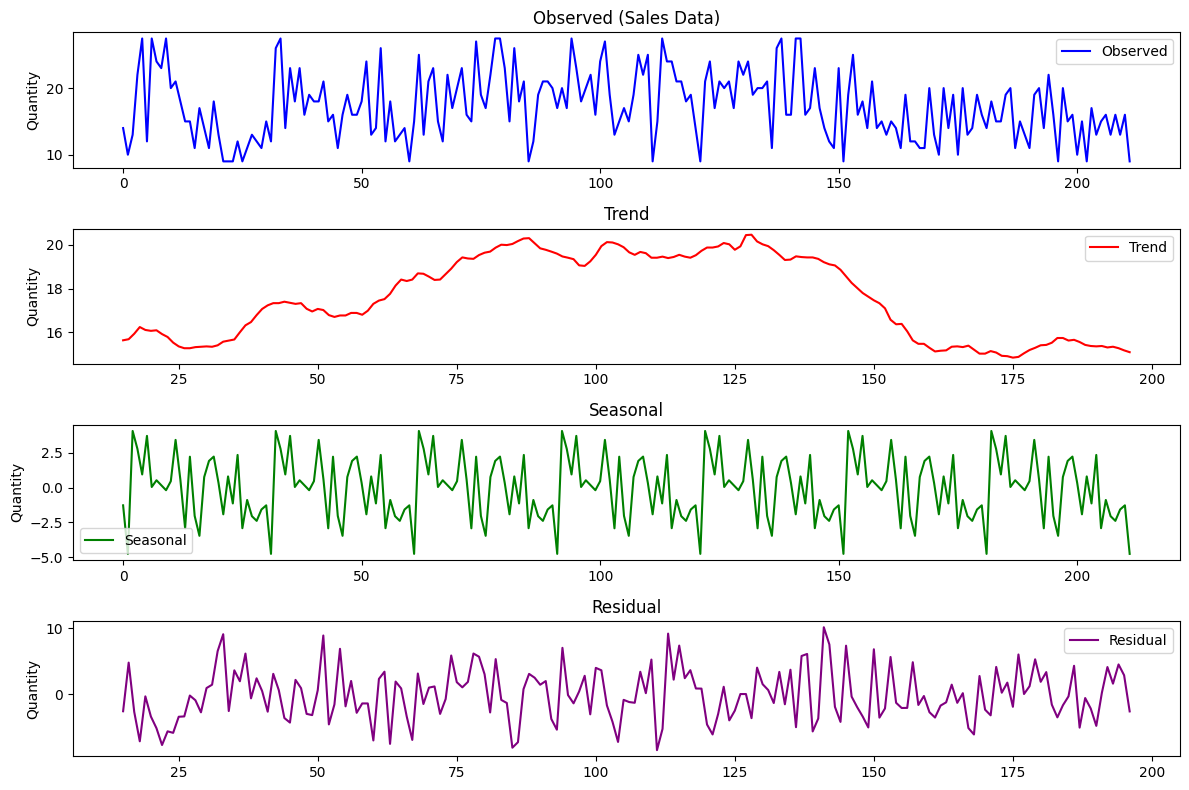

In [26]:
# Decompose the sales data to analyze seasonality
result = seasonal_decompose(merged_df['Quantity'], model='additive', period=30)

# Plot the decomposition
plt.figure(figsize=(12, 8))

# Plotting the decomposed components
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed', color='blue')
plt.title('Observed (Sales Data)')
plt.ylabel('Quantity')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='red')
plt.title('Trend')
plt.ylabel('Quantity')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.ylabel('Quantity')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='purple')
plt.title('Residual')
plt.ylabel('Quantity')
plt.legend()

plt.tight_layout()
plt.show()


## **Autocorrelation**

<Figure size 1200x600 with 0 Axes>

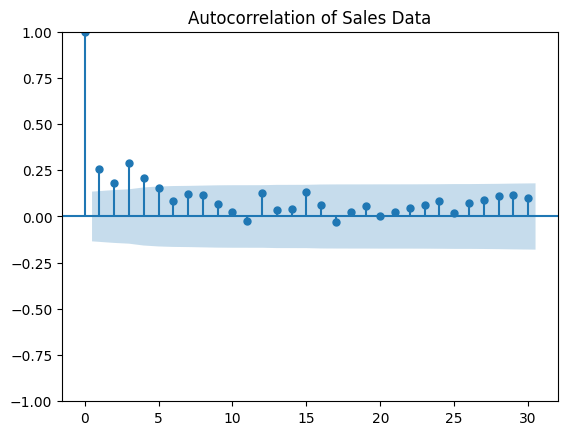

<Figure size 1200x600 with 0 Axes>

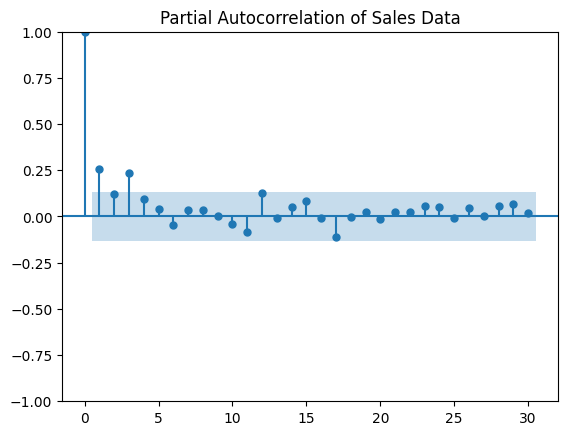

In [27]:
# Plot autocorrelation and partial autocorrelation for sales data
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Quantity'], lags=30)
plt.title('Autocorrelation of Sales Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Quantity'], lags=30)
plt.title('Partial Autocorrelation of Sales Data')
plt.show()

ACF Plot

Significant positive autocorrelation at lag 1, followed by smaller positive and negative correlations that quickly become statistically insignificant.
Indicates a short memory process with dependencies primarily at the first few lags.

PACF Plot:

A significant spike at lag 1 and some smaller spikes at subsequent lags, but these quickly fall within the confidence bounds.
Suggests that the primary autocorrelation is mostly at the first lag.

<Figure size 1200x600 with 0 Axes>

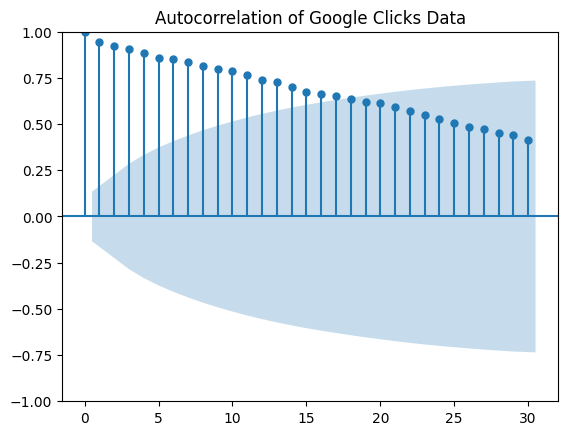

<Figure size 1200x600 with 0 Axes>

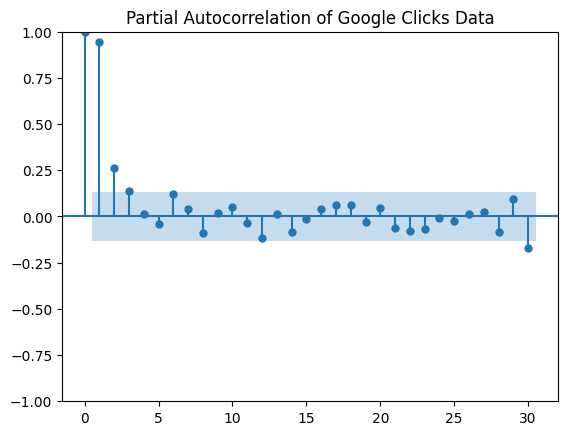

In [28]:
# Plot autocorrelation and partial autocorrelation for sales data
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Clicks'], lags=30)
plt.title('Autocorrelation of Google Clicks Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Clicks'], lags=30)
plt.title('Partial Autocorrelation of Google Clicks Data')
plt.show()

ACF Plot

Strong positive autocorrelation at multiple lags, indicating a slowly decaying pattern.
The autocorrelations remain significant for a long number of lags, suggesting the presence of a long memory process.

PACF Plot:

A significant spike at lag 1, followed by smaller spikes at subsequent lags, but none are as prominent as the first lag.
Indicates that the primary autocorrelation is captured by the first lag, but there might be some underlying pattern.

<Figure size 1200x600 with 0 Axes>

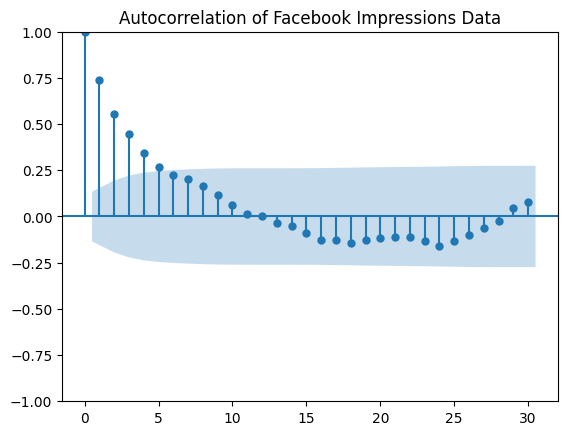

<Figure size 1200x600 with 0 Axes>

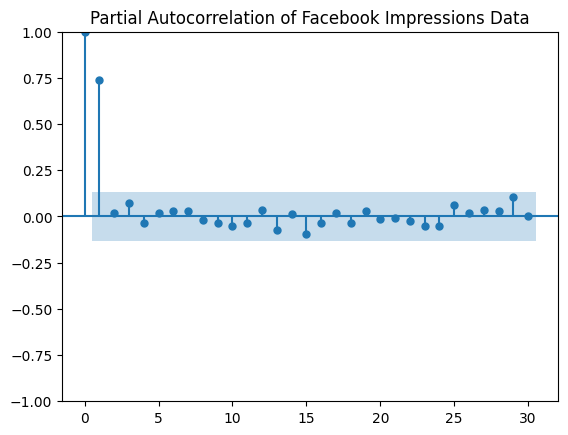

In [29]:
# Plot autocorrelation and partial autocorrelation for sales data
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Impressions'], lags=30)
plt.title('Autocorrelation of Facebook Impressions Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Impressions'], lags=30)
plt.title('Partial Autocorrelation of Facebook Impressions Data')
plt.show()

ACF Plot:

Significant positive autocorrelation is observed at lags up to around 10.
After lag 10, the autocorrelations become mostly negative and gradually decrease in magnitude until they become statistically insignificant.

PACF Plot:

The PACF shows a significant spike at lag 1 and smaller significant spikes at lags 2 and 3.
The rest of the lags fall within the confidence bounds, indicating that the autocorrelations are explained mostly by the first few lags.

<Figure size 1000x500 with 0 Axes>

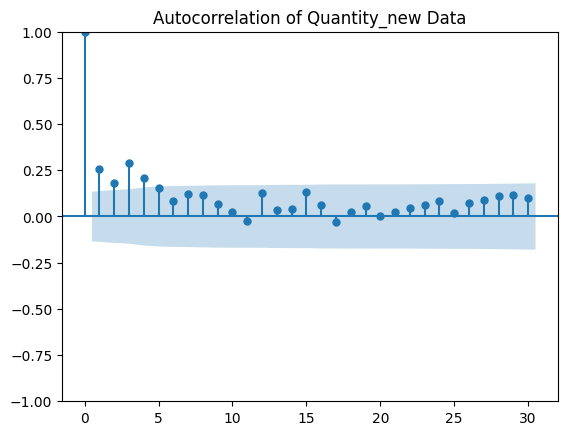

<Figure size 1000x500 with 0 Axes>

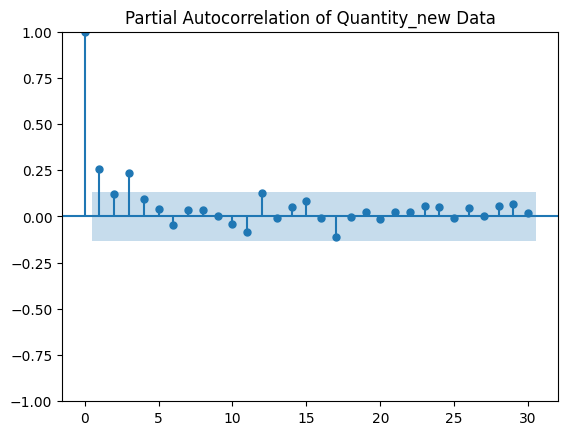

In [30]:
# Plot autocorrelation and partial autocorrelation for Quantity_new
plt.figure(figsize=(10, 5))
plot_acf(merged_df['Quantity_new'], lags=30)
plt.title('Autocorrelation of Quantity_new Data')
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(merged_df['Quantity_new'], lags=30)
plt.title('Partial Autocorrelation of Quantity_new Data')
plt.show()



**Consider the training, testing, and validation set**

In [31]:
# Ensure the data is sorted by date
merged_df = merged_df.sort_values(by='Day Index').reset_index(drop=True)

# Calculate the indices for the splits
train_size = int(len(merged_df) * 0.80)
test_size = int(len(merged_df) * 0.10)
validation_size = len(merged_df) - train_size - test_size

# Split the data
train_set = merged_df[:train_size]
test_set = merged_df[train_size:train_size + test_size]
validation_set = merged_df[train_size + test_size:]

# Display the sizes of each set
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")
print(f"Validation set size: {len(validation_set)}")


Training set size: 169
Testing set size: 21
Validation set size: 22


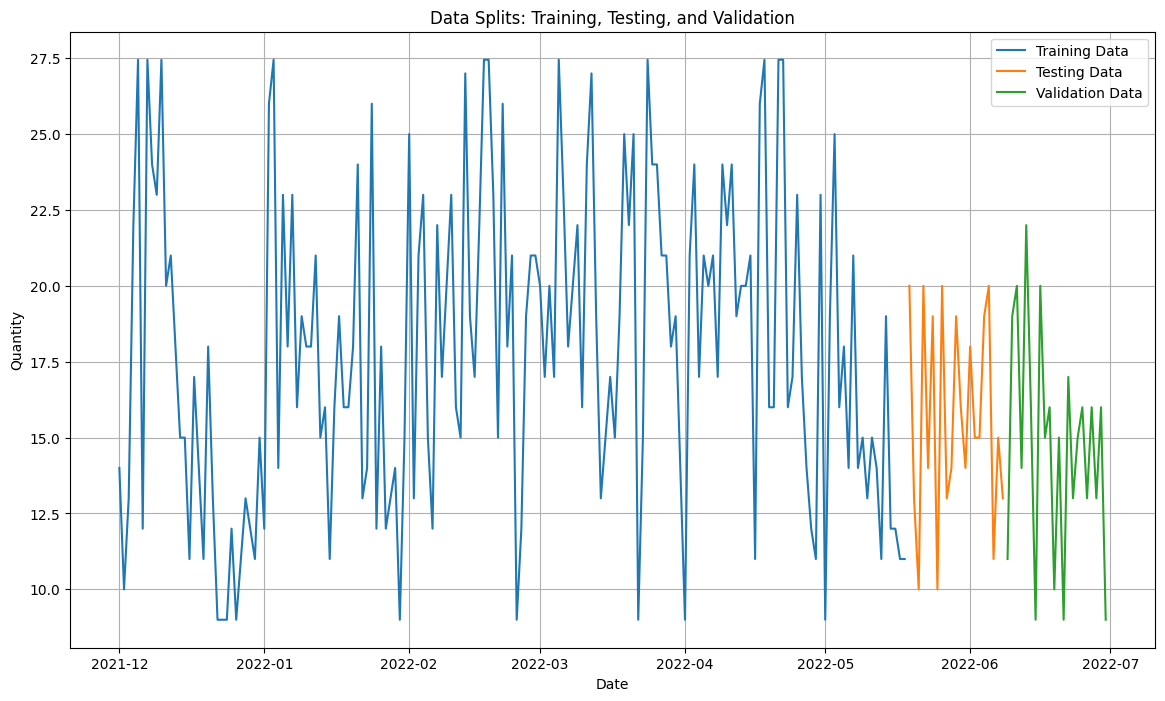

In [32]:
# Visualize the data splits
plt.figure(figsize=(14, 8))

plt.plot(train_set['Day Index'], train_set['Quantity'], label='Training Data')
plt.plot(test_set['Day Index'], test_set['Quantity'], label='Testing Data')
plt.plot(validation_set['Day Index'], validation_set['Quantity'], label='Validation Data')

plt.title('Data Splits: Training, Testing, and Validation')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Assuming train_set, test_set, and validation_set are already defined

# Define columns to be converted to numeric
numeric_columns = ['Quantity', 'Clicks', 'Impressions', 'Day', 'Year']

# Convert columns to numeric types for train and test sets
train_set[numeric_columns] = train_set[numeric_columns].apply(pd.to_numeric)
test_set[numeric_columns] = test_set[numeric_columns].apply(pd.to_numeric)
validation_set[numeric_columns] = validation_set[numeric_columns].apply(pd.to_numeric)

# Convert 'Month' to dummy variables if it exists in the DataFrame
if 'Month' in train_set.columns and 'Month' in test_set.columns and 'Month' in validation_set.columns:
    train_set = pd.get_dummies(train_set, columns=['Month'], drop_first=True)
    test_set = pd.get_dummies(test_set, columns=['Month'], drop_first=True)
    validation_set = pd.get_dummies(validation_set, columns=['Month'], drop_first=True)

# Ensure both train and test sets have the same columns after get_dummies
missing_cols = set(train_set.columns) - set(test_set.columns)
for col in missing_cols:
    test_set[col] = 0
test_set = test_set[train_set.columns]

# Ensure both train and validation sets have the same columns after get_dummies
missing_cols = set(train_set.columns) - set(validation_set.columns)
for col in missing_cols:
    validation_set[col] = 0
validation_set = validation_set[train_set.columns]

# Standardize data types for all columns
for col in train_set.columns:
    if train_set[col].dtype == 'bool':
        train_set[col] = train_set[col].astype(int)
    if test_set[col].dtype == 'bool':
        test_set[col] = test_set[col].astype(int)
    if validation_set[col].dtype == 'bool':
        validation_set[col] = validation_set[col].astype(int)

# Define exogenous variables
exog_vars = ['Clicks', 'Impressions', 'Day', 'Year'] + [col for col in train_set.columns if col.startswith('Month_')]

# Ensure the target variable in validation set is numeric
validation_set['Quantity_new'] = pd.to_numeric(validation_set['Quantity_new'], errors='coerce')

# Print to verify the changes
print("Train set column types:\n", train_set.dtypes)
print("Test set column types:\n", test_set.dtypes)
print("Validation set column types:\n", validation_set.dtypes)

<ipython-input-33-dff82447f31e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[numeric_columns] = train_set[numeric_columns].apply(pd.to_numeric)
<ipython-input-33-dff82447f31e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[numeric_columns] = test_set[numeric_columns].apply(pd.to_numeric)
<ipython-input-33-dff82447f31e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Train set column types:
 Day Index         datetime64[ns]
Quantity                 float64
Clicks                   float64
Impressions              float64
Quantity_new             float64
Day                        int32
Year                       int32
Month_December             int64
Month_February             int64
Month_January              int64
Month_March                int64
Month_May                  int64
dtype: object
Test set column types:
 Day Index         datetime64[ns]
Quantity                 float64
Clicks                   float64
Impressions              float64
Quantity_new             float64
Day                        int32
Year                       int32
Month_December             int64
Month_February             int64
Month_January              int64
Month_March                int64
Month_May                  int64
dtype: object
Validation set column types:
 Day Index         datetime64[ns]
Quantity                 float64
Clicks                   float64
Im

In [34]:
# Print the training set
print("Training Set:")
print(train_set)

# Print the testing set
print("Testing Set:")
print(test_set)

# Print the validation set
print("Validation Set:")
print(validation_set)


Training Set:
     Day Index  Quantity  Clicks  Impressions  Quantity_new  Day  Year  \
0   2021-12-01     14.00  445.00        883.2         14.00    1  2021   
1   2021-12-02     10.00  433.00        890.0         10.00    2  2021   
2   2021-12-03     13.00  424.00        883.2         13.00    3  2021   
3   2021-12-04     22.00  427.00        883.2         22.00    4  2021   
4   2021-12-05     27.45  451.00        883.2         27.45    5  2021   
..         ...       ...     ...          ...           ...  ...   ...   
164 2022-05-14     19.00  260.00       1771.0         19.00   14  2022   
165 2022-05-15     12.00  129.00       1584.0         12.00   15  2022   
166 2022-05-16     12.00  156.00       1459.0         12.00   16  2022   
167 2022-05-17     11.00  110.55       1232.0         11.00   17  2022   
168 2022-05-18     11.00  110.55       1578.0         11.00   18  2022   

     Month_December  Month_February  Month_January  Month_March  Month_May  
0                 1 

## **Exogenous Variables**

In [35]:
# Print the first few rows of the exogenous variables in the training set
print("Training Set Exogenous Variables:")
print(train_set[exog_vars].head())
# Print the first few rows of the exogenous variables in the testing set
print("Testing Set Exogenous Variables:")
print(test_set[exog_vars].head())
# Print the first few rows of the exogenous variables in the validation set
print("Validation Set Exogenous Variables:")
print(validation_set[exog_vars].head())


Training Set Exogenous Variables:
   Clicks  Impressions  Day  Year  Month_December  Month_February  \
0   445.0        883.2    1  2021               1               0   
1   433.0        890.0    2  2021               1               0   
2   424.0        883.2    3  2021               1               0   
3   427.0        883.2    4  2021               1               0   
4   451.0        883.2    5  2021               1               0   

   Month_January  Month_March  Month_May  
0              0            0          0  
1              0            0          0  
2              0            0          0  
3              0            0          0  
4              0            0          0  
Testing Set Exogenous Variables:
     Clicks  Impressions  Day  Year  Month_December  Month_February  \
169   114.0       1266.0   19  2022               0               0   
170   113.0       1629.0   20  2022               0               0   
171   113.0       1279.0   21  2022            

## **AR Model**

AR Model - Test Data: RMSE: 4.053696989174093, MAE: 3.4664134036843794, MAPE: 26.261311755936145
AR Model - Validation Data: RMSE: 4.695969917124517, MAE: 3.971442008795412, MAPE: 33.34248348138772


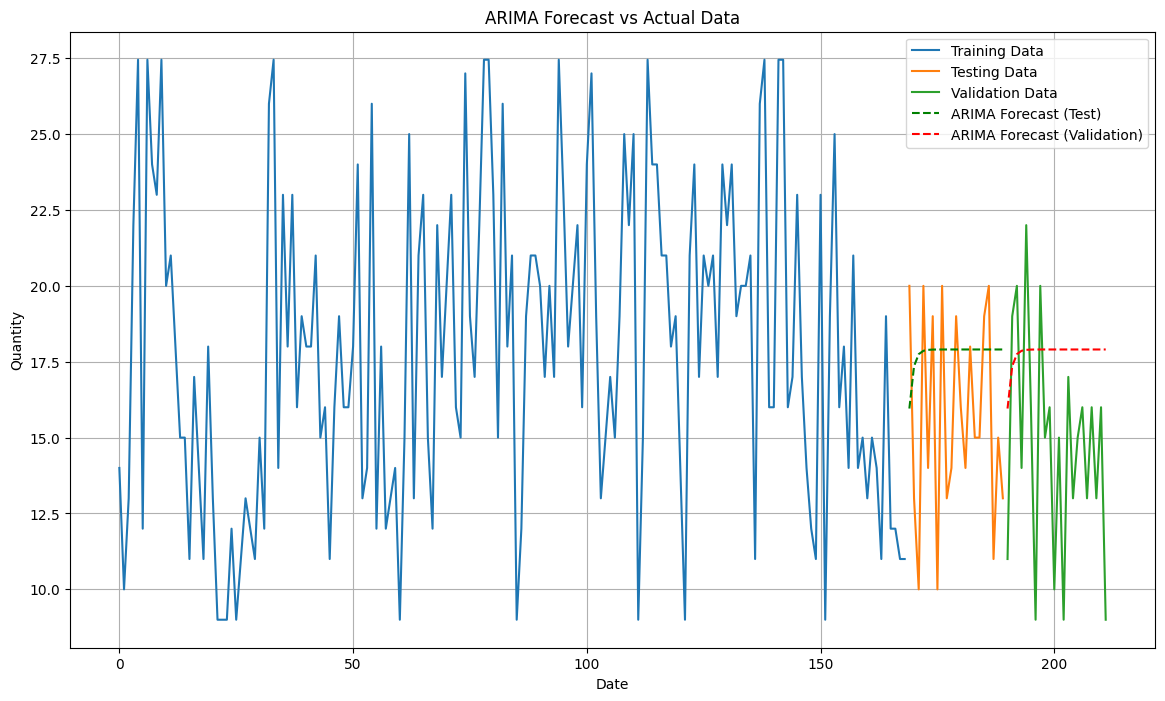

In [36]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# AR model
ar_order = (1, 0, 0)
ar_model, ar_forecast_test = fit_and_forecast_arima(train_target, ar_order, len(test_target))
_, ar_forecast_validation = fit_and_forecast_arima(train_target, ar_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# AR model metrics
ar_rmse_test, ar_mae_test, ar_mape_test = calculate_metrics(test_target, ar_forecast_test)
ar_rmse_validation, ar_mae_validation, ar_mape_validation = calculate_metrics(validation_target, ar_forecast_validation)

# Print the metrics
print(f"AR Model - Test Data: RMSE: {ar_rmse_test}, MAE: {ar_mae_test}, MAPE: {ar_mape_test}")
print(f"AR Model - Validation Data: RMSE: {ar_rmse_validation}, MAE: {ar_mae_validation}, MAPE: {ar_mape_validation}")
def plot_arima_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot ARIMA forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='ARIMA Forecast (Test)')

    # Plot ARIMA forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='ARIMA Forecast (Validation)')

    plt.title('ARIMA Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot ARIMA forecast
plot_arima_forecast(train_target, test_target, validation_target, ar_forecast_test, ar_forecast_validation)

**Model Performance:** The AR model has moderate predictive performance. The errors (RMSE, MAE, and MAPE) indicate that the model's accuracy is decent but not highly precise, especially on the validation set. The higher errors on the validation set suggest potential overfitting on the training data.



## **MA Model**

MA Model - Test Data: RMSE: 4.081365968277927, MAE: 3.4767244926538337, MAPE: 26.442543545198237
MA Model - Validation Data: RMSE: 4.721635168088548, MAE: 3.97308815981558, MAPE: 33.47560641571583


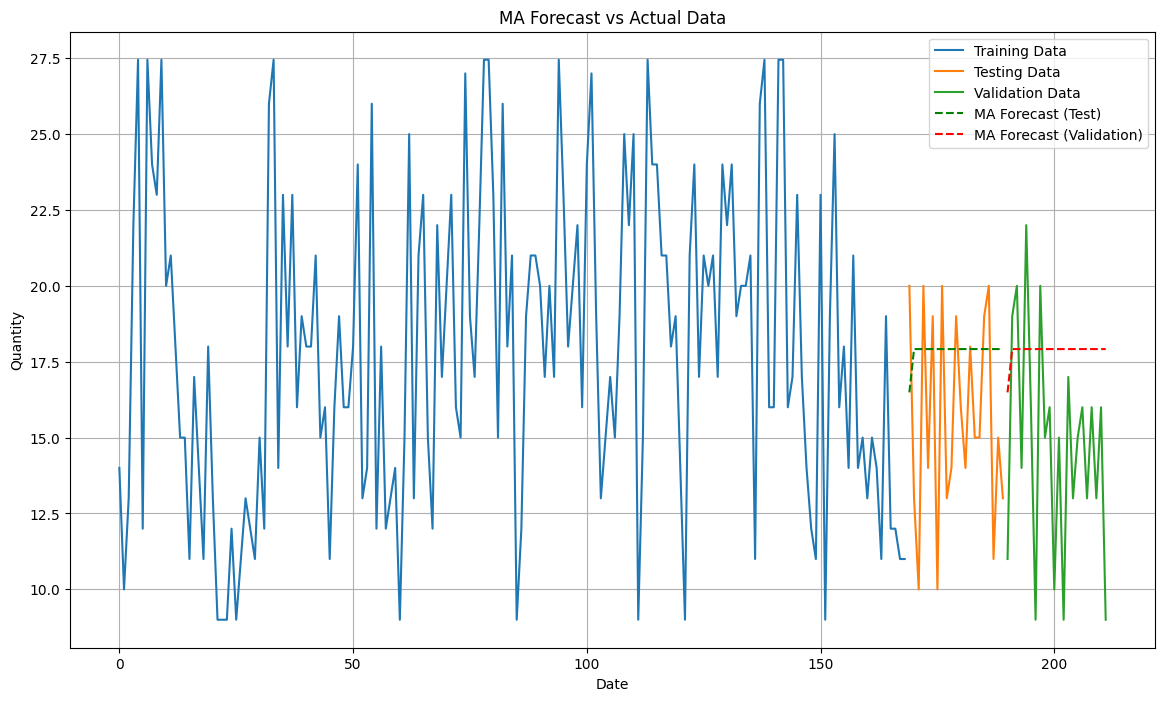

In [37]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# MA model
ma_order = (0, 0, 1)
ma_model, ma_forecast_test = fit_and_forecast_arima(train_target, ma_order, len(test_target))
_, ma_forecast_validation = fit_and_forecast_arima(train_target, ma_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# MA model metrics
ma_rmse_test, ma_mae_test, ma_mape_test = calculate_metrics(test_target, ma_forecast_test)
ma_rmse_validation, ma_mae_validation, ma_mape_validation = calculate_metrics(validation_target, ma_forecast_validation)

# Print the metrics
print(f"MA Model - Test Data: RMSE: {ma_rmse_test}, MAE: {ma_mae_test}, MAPE: {ma_mape_test}")
print(f"MA Model - Validation Data: RMSE: {ma_rmse_validation}, MAE: {ma_mae_validation}, MAPE: {ma_mape_validation}")
# Define a function to plot the MA forecast
def plot_ma_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot MA forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='MA Forecast (Test)')

    # Plot MA forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='MA Forecast (Validation)')

    plt.title('MA Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MA forecast
plot_ma_forecast(train_target, test_target, validation_target, ma_forecast_test, ma_forecast_validation)

## **ARIMA Model**

ARIMA Model - Test Data: RMSE: 3.684558807820178, MAE: 3.2805845556772306, MAPE: 23.710994586889647
ARIMA Model - Validation Data: RMSE: 4.491520522291185, MAE: 3.763339581403525, MAPE: 30.78306104198758


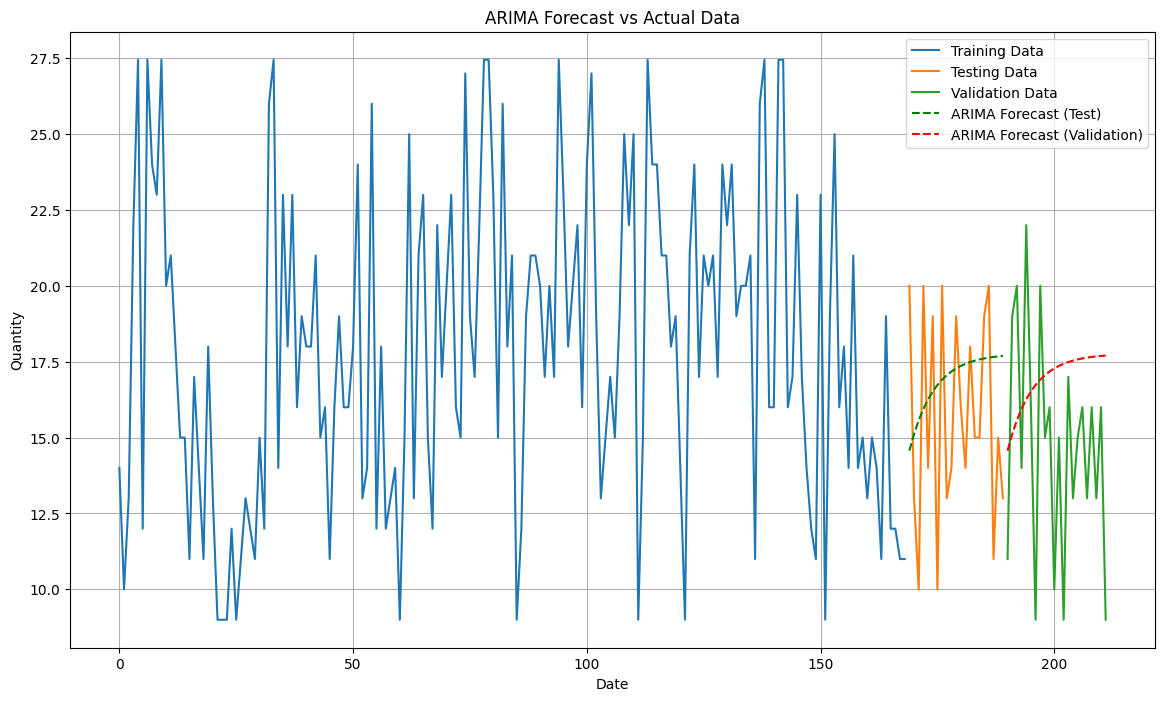

In [38]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# ARIMA model
arima_order = (1, 0, 1)
arima_model, arima_forecast_test = fit_and_forecast_arima(train_target, arima_order, len(test_target))
_, arima_forecast_validation = fit_and_forecast_arima(train_target, arima_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# ARIMA model metrics
arima_rmse_test, arima_mae_test, arima_mape_test = calculate_metrics(test_target, arima_forecast_test)
arima_rmse_validation, arima_mae_validation, arima_mape_validation = calculate_metrics(validation_target, arima_forecast_validation)

# Print the metrics
print(f"ARIMA Model - Test Data: RMSE: {arima_rmse_test}, MAE: {arima_mae_test}, MAPE: {arima_mape_test}")
print(f"ARIMA Model - Validation Data: RMSE: {arima_rmse_validation}, MAE: {arima_mae_validation}, MAPE: {arima_mape_validation}")
# Define a function to plot the ARIMA forecast
def plot_arima_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot ARIMA forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='ARIMA Forecast (Test)')

    # Plot ARIMA forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='ARIMA Forecast (Validation)')

    plt.title('ARIMA Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot ARIMA forecast
plot_arima_forecast(train_target, test_target, validation_target, arima_forecast_test, arima_forecast_validation)

## **Auto ARIMA Model**

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1035.092, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1470.866, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1098.979, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1322.029, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1034.682, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1259.724, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1034.524, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1034.922, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1072.146, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1024.739, Time=2.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1030.569, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1029.109, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1026.675, Time=2.72 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1026.622, Time=1.67 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept

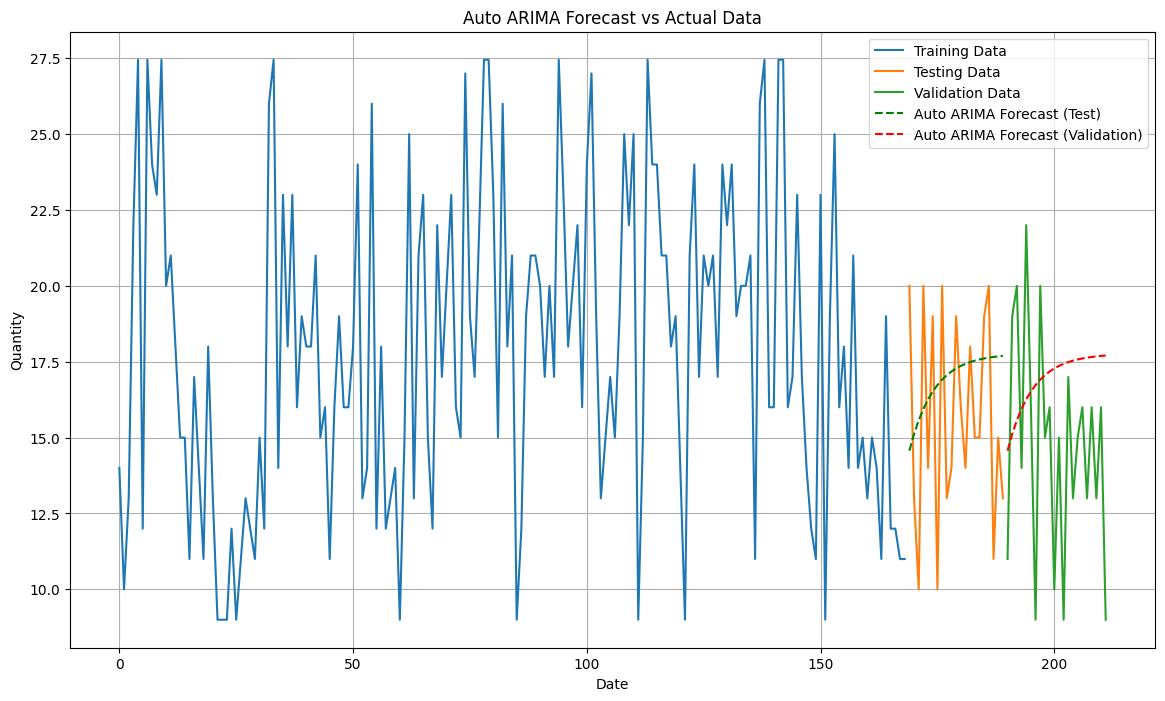

In [39]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Fit and forecast using Auto ARIMA
auto_arima_model = pm.auto_arima(train_target, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
auto_arima_forecast_test = auto_arima_model.predict(n_periods=len(test_target))
auto_arima_forecast_validation = auto_arima_model.predict(n_periods=len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# Auto ARIMA model metrics
auto_arima_rmse_test, auto_arima_mae_test, auto_arima_mape_test = calculate_metrics(test_target, auto_arima_forecast_test)
auto_arima_rmse_validation, auto_arima_mae_validation, auto_arima_mape_validation = calculate_metrics(validation_target, auto_arima_forecast_validation)

# Print the metrics
print(f"Auto ARIMA Model - Test Data: RMSE: {auto_arima_rmse_test}, MAE: {auto_arima_mae_test}, MAPE: {auto_arima_mape_test}")
print(f"Auto ARIMA Model - Validation Data: RMSE: {auto_arima_rmse_validation}, MAE: {auto_arima_mae_validation}, MAPE: {auto_arima_mape_validation}")
# Define a function to plot the Auto ARIMA forecast
def plot_auto_arima_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot Auto ARIMA forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='Auto ARIMA Forecast (Test)')

    # Plot Auto ARIMA forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='Auto ARIMA Forecast (Validation)')

    plt.title('Auto ARIMA Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Auto ARIMA forecast
plot_auto_arima_forecast(train_target, test_target, validation_target, auto_arima_forecast_test, auto_arima_forecast_validation)

## **SARIMA Model**

SARIMA Model - Test Data: RMSE: 4.437369484427865, MAE: 3.6184675610233334, MAPE: 21.217071681510028
SARIMA Model - Validation Data: RMSE: 4.1049023311059045, MAE: 3.4408672882420706, MAPE: 22.69937233314921


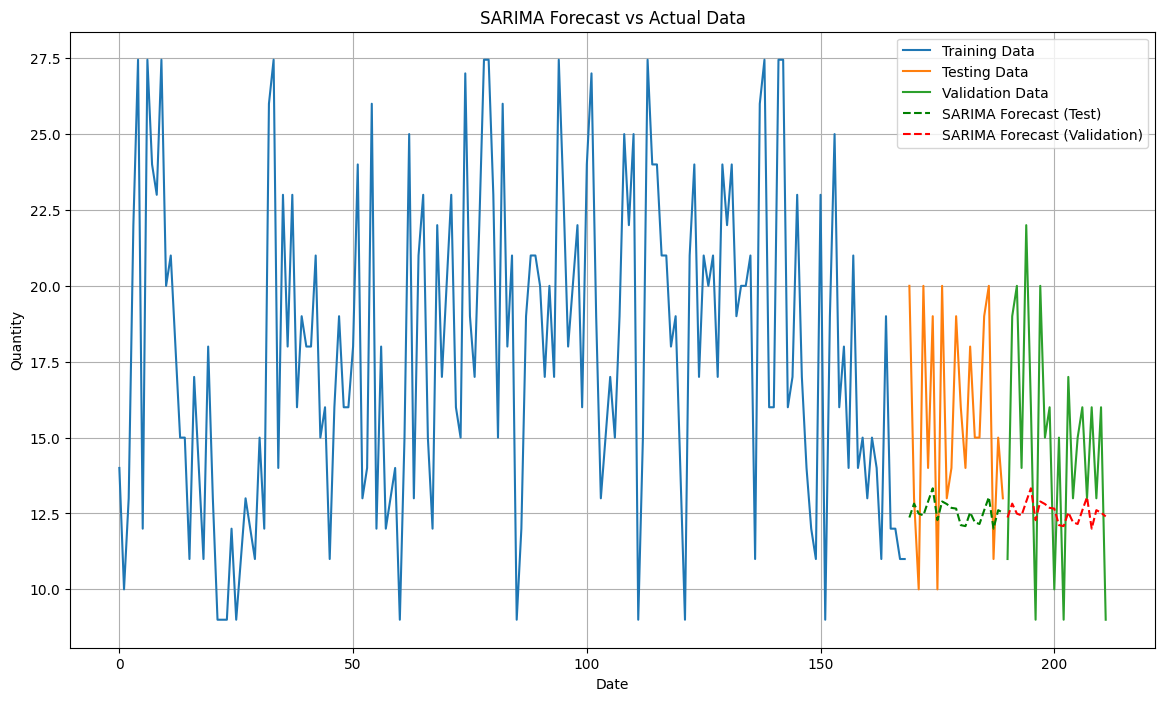

In [40]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Define the function to fit and forecast using SARIMA
def fit_and_forecast_sarima(train, order, seasonal_order, steps):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# SARIMA model
sarima_order = (1, 0, 1)  # Non-seasonal part of the SARIMA model (p, d, q)
seasonal_order = (1, 0, 1, 12)  # Seasonal part of the SARIMA model (P, D, Q, s) where s is the number of periods in a season
sarima_model, sarima_forecast_test = fit_and_forecast_sarima(train_target, sarima_order, seasonal_order, len(test_target))
_, sarima_forecast_validation = fit_and_forecast_sarima(train_target, sarima_order, seasonal_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# SARIMA model metrics
sarima_rmse_test, sarima_mae_test, sarima_mape_test = calculate_metrics(test_target, sarima_forecast_test)
sarima_rmse_validation, sarima_mae_validation, sarima_mape_validation = calculate_metrics(validation_target, sarima_forecast_validation)

# Print the metrics
print(f"SARIMA Model - Test Data: RMSE: {sarima_rmse_test}, MAE: {sarima_mae_test}, MAPE: {sarima_mape_test}")
print(f"SARIMA Model - Validation Data: RMSE: {sarima_rmse_validation}, MAE: {sarima_mae_validation}, MAPE: {sarima_mape_validation}")

# Define a function to plot the SARIMA forecast
def plot_sarima_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot SARIMA forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='SARIMA Forecast (Test)')

    # Plot SARIMA forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='SARIMA Forecast (Validation)')

    plt.title('SARIMA Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot SARIMA forecast
plot_sarima_forecast(train_target, test_target, validation_target, sarima_forecast_test, sarima_forecast_validation)

## **ARIMAX Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMAX Model - Test Data: RMSE: 4.213010160763354, MAE: 3.4335494355352023, MAPE: 21.187509935216163
ARIMAX Model - Validation Data: RMSE: 3.48015464338128, MAE: 2.82531509786188, MAPE: 21.54014788412895


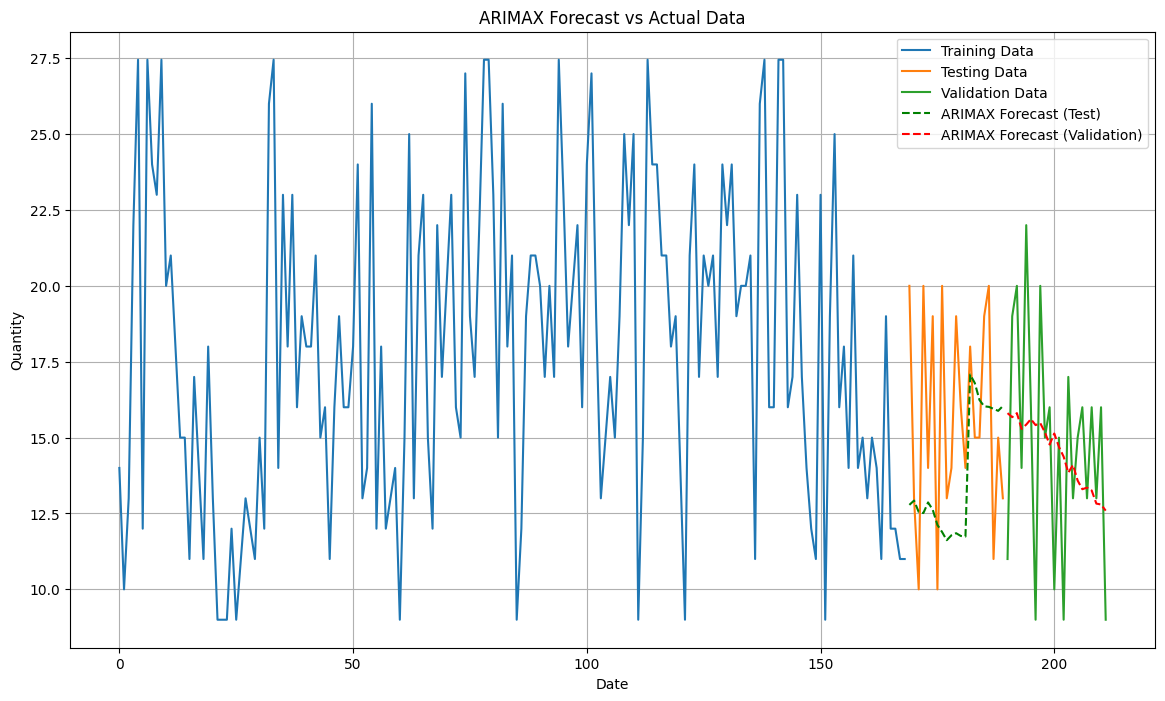

In [41]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Extract the exogenous variables
exog_vars = ['Clicks', 'Impressions', 'Day', 'Year', 'Month_December', 'Month_February', 'Month_January', 'Month_March', 'Month_May']
train_exog = train_set[exog_vars]
test_exog = test_set[exog_vars]
validation_exog = validation_set[exog_vars]

# Define the function to fit and forecast using SARIMAX (with no seasonality for ARIMAX)
def fit_and_forecast_sarimax(train, exog_train, order, seasonal_order, exog_test, steps):
    model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=steps, exog=exog_test).predicted_mean
    return model_fit, forecast

# ARIMAX model
arimax_order = (1, 0, 1)
arimax_model, arimax_forecast_test = fit_and_forecast_sarimax(train_target, train_exog, arimax_order, (0, 0, 0, 0), test_exog, len(test_target))
_, arimax_forecast_validation = fit_and_forecast_sarimax(train_target, train_exog, arimax_order, (0, 0, 0, 0), validation_exog, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# ARIMAX model metrics
arimax_rmse_test, arimax_mae_test, arimax_mape_test = calculate_metrics(test_target, arimax_forecast_test)
arimax_rmse_validation, arimax_mae_validation, arimax_mape_validation = calculate_metrics(validation_target, arimax_forecast_validation)

# Print the metrics
print(f"ARIMAX Model - Test Data: RMSE: {arimax_rmse_test}, MAE: {arimax_mae_test}, MAPE: {arimax_mape_test}")
print(f"ARIMAX Model - Validation Data: RMSE: {arimax_rmse_validation}, MAE: {arimax_mae_validation}, MAPE: {arimax_mape_validation}")

# Define a function to plot the ARIMAX forecast
def plot_arimax_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot ARIMAX forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='ARIMAX Forecast (Test)')

    # Plot ARIMAX forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='ARIMAX Forecast (Validation)')

    plt.title('ARIMAX Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot ARIMAX forecast
plot_arimax_forecast(train_target, test_target, validation_target, arimax_forecast_test, arimax_forecast_validation)

## **SARIMAX Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMAX Model - Test Data: RMSE: 4.235821468453355, MAE: 3.4357664630732394, MAPE: 21.033529363601726
SARIMAX Model - Validation Data: RMSE: 3.4814450288664314, MAE: 2.8447542125311536, MAPE: 21.495270465810297


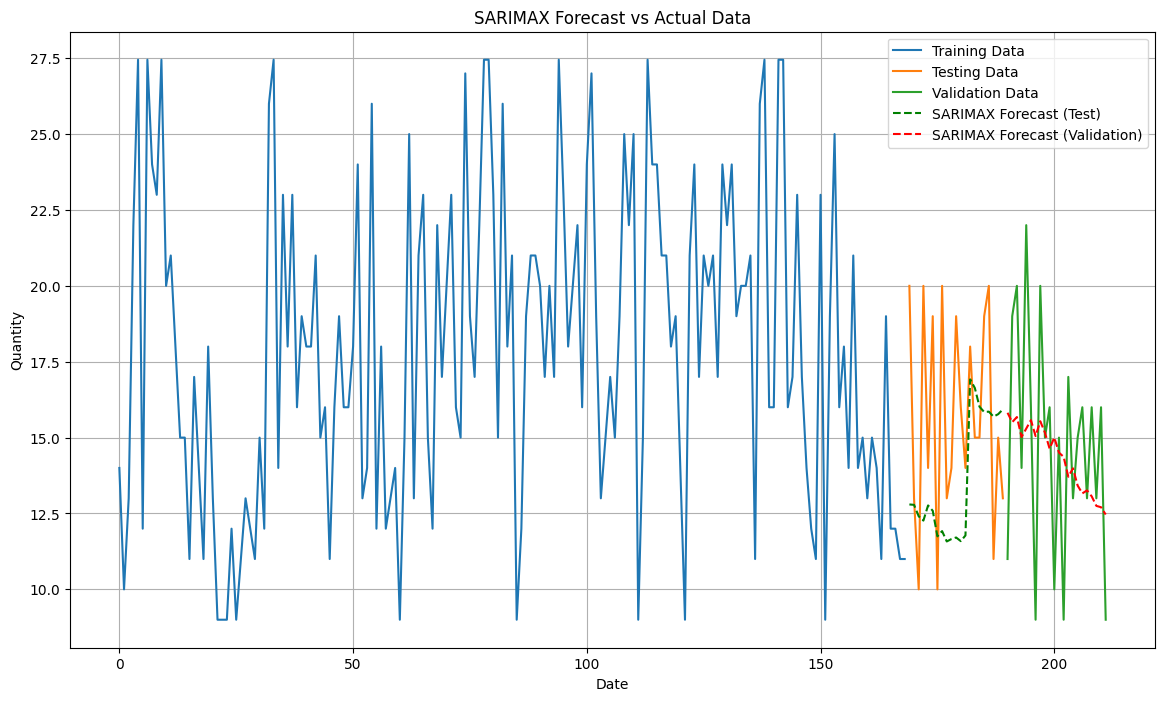

In [42]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Extract the exogenous variables
exog_vars = ['Clicks', 'Impressions', 'Day', 'Year', 'Month_December', 'Month_February', 'Month_January', 'Month_March', 'Month_May']
train_exog = train_set[exog_vars]
test_exog = test_set[exog_vars]
validation_exog = validation_set[exog_vars]

# Define the function to fit and forecast using SARIMAX
def fit_and_forecast_sarimax(train, exog_train, order, seasonal_order, exog_test, steps):
    model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=steps, exog=exog_test).predicted_mean
    return model_fit, forecast

# SARIMAX model
sarimax_order = (1, 0, 1)
seasonal_order = (1, 0, 1, 12)
sarimax_model, sarimax_forecast_test = fit_and_forecast_sarimax(train_target, train_exog, sarimax_order, seasonal_order, test_exog, len(test_target))
_, sarimax_forecast_validation = fit_and_forecast_sarimax(train_target, train_exog, sarimax_order, seasonal_order, validation_exog, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# SARIMAX model metrics
sarimax_rmse_test, sarimax_mae_test, sarimax_mape_test = calculate_metrics(test_target, sarimax_forecast_test)
sarimax_rmse_validation, sarimax_mae_validation, sarimax_mape_validation = calculate_metrics(validation_target, sarimax_forecast_validation)

# Print the metrics
print(f"SARIMAX Model - Test Data: RMSE: {sarimax_rmse_test}, MAE: {sarimax_mae_test}, MAPE: {sarimax_mape_test}")
print(f"SARIMAX Model - Validation Data: RMSE: {sarimax_rmse_validation}, MAE: {sarimax_mae_validation}, MAPE: {sarimax_mape_validation}")

# Define a function to plot the SARIMAX forecast
def plot_sarimax_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot SARIMAX forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='SARIMAX Forecast (Test)')

    # Plot SARIMAX forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='SARIMAX Forecast (Validation)')

    plt.title('SARIMAX Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot SARIMAX forecast
plot_sarimax_forecast(train_target, test_target, validation_target, sarimax_forecast_test, sarimax_forecast_validation)

In [43]:
# Example functions for illustration
def calculate_r_squared(true_values, predictions):
    ss_total = np.sum((true_values - np.mean(true_values))**2)
    ss_res = np.sum((true_values - predictions)**2)
    r_squared = 1 - (ss_res / ss_total)
    return r_squared

def calculate_adjusted_r_squared(r_squared, n, k):
    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
    return adjusted_r_squared

# Example data
models_forecasts = {
    "AR": (ar_forecast_test, ar_forecast_validation),
    "MA": (ma_forecast_test, ma_forecast_validation),
    "ARIMA": (arima_forecast_test, arima_forecast_validation),
    "Auto ARIMA": (auto_arima_forecast_test, auto_arima_forecast_validation),
    "SARIMA": (sarima_forecast_test, sarima_forecast_validation),
    "ARIMAX": (arimax_forecast_test, arimax_forecast_validation),
    "SARIMAX": (sarimax_forecast_test, sarimax_forecast_validation)
}

def calculate_all_metrics(true_values, predictions, num_params):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    r_squared = calculate_r_squared(true_values, predictions)
    adjusted_r_squared = calculate_adjusted_r_squared(r_squared, len(true_values), num_params)
    return r_squared, adjusted_r_squared

for model_name, (forecast_test, forecast_validation) in models_forecasts.items():
    num_params = len(train_exog.columns) if "ARIMAX" in model_name or "SARIMAX" in model_name else 1
    test_metrics = calculate_all_metrics(test_target, forecast_test, num_params)
    validation_metrics = calculate_all_metrics(validation_target, forecast_validation, num_params)
    print(f"{model_name} Model - Test Data: R²: {test_metrics[0]}, Adjusted R²: {test_metrics[1]}")
    print(f"{model_name} Model - Validation Data: R²: {validation_metrics[0]}, Adjusted R²: {validation_metrics[1]}")


AR Model - Test Data: R²: -0.49416794690664867, Adjusted R²: -0.5728083651648932
AR Model - Validation Data: R²: 0.8323997723230134, Adjusted R²: 0.8240197609391641
MA Model - Test Data: R²: -0.5146347920937306, Adjusted R²: -0.5943524127302426
MA Model - Validation Data: R²: 0.8317573608946275, Adjusted R²: 0.8233452289393588
ARIMA Model - Test Data: R²: -0.2344338889183084, Adjusted R²: -0.2994040935982194
ARIMA Model - Validation Data: R²: 0.841933962077902, Adjusted R²: 0.8340306601817972
Auto ARIMA Model - Test Data: R²: -0.23427671685939777, Adjusted R²: -0.299238649325682
Auto ARIMA Model - Validation Data: R²: 0.8419588691082599, Adjusted R²: 0.8340568125636729
SARIMA Model - Test Data: R²: -0.7903916169334524, Adjusted R²: -0.8846227546667917
SARIMA Model - Validation Data: R²: 0.9930840770299366, Adjusted R²: 0.9927382808814335
ARIMAX Model - Test Data: R²: -0.6139194814599198, Adjusted R²: -1.9343990571998542
ARIMAX Model - Validation Data: R²: 0.9910714951907733, Adjusted R

## **Multivariate Linear Regression**

In [44]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity_new']
test_target = test_set['Quantity_new']
validation_target = validation_set['Quantity_new']

# Extract the exogenous variables
exog_vars = ['Clicks', 'Impressions', 'Day', 'Year', 'Month_December', 'Month_February', 'Month_January', 'Month_March', 'Month_May']
train_exog = train_set[exog_vars]
test_exog = test_set[exog_vars]
validation_exog = validation_set[exog_vars]
# Ensure all exog variables are present in test and validation sets
for col in exog_vars:
    if col not in test_exog.columns:
        test_exog[col] = 0
    if col not in validation_exog.columns:
        validation_exog[col] = 0

# Add a constant term to the predictors (for the intercept)
train_exog = sm.add_constant(train_exog)
test_exog = sm.add_constant(test_exog)
validation_exog = sm.add_constant(validation_exog)

# Align columns
test_exog = test_exog.reindex(columns=train_exog.columns, fill_value=0)
validation_exog = validation_exog.reindex(columns=train_exog.columns, fill_value=0)

# Fit the linear regression model
model = sm.OLS(train_target, train_exog).fit()
# Make predictions
train_predictions = model.predict(train_exog)
test_predictions = model.predict(test_exog)
validation_predictions = model.predict(validation_exog)

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

def calculate_r_squared(true_values, predictions):
    ss_total = np.sum((true_values - np.mean(true_values))**2)
    ss_res = np.sum((true_values - predictions)**2)
    r_squared = 1 - (ss_res / ss_total)
    return r_squared

def calculate_adjusted_r_squared(r_squared, n, k):
    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
    return adjusted_r_squared
# Calculate metrics for test data
test_rmse, test_mae, test_mape = calculate_metrics(test_target, test_predictions)
test_r_squared = calculate_r_squared(test_target, test_predictions)
test_adjusted_r_squared = calculate_adjusted_r_squared(test_r_squared, len(test_target), len(exog_vars) + 1)

# Calculate metrics for validation data
validation_rmse, validation_mae, validation_mape = calculate_metrics(validation_target, validation_predictions)
validation_r_squared = calculate_r_squared(validation_target, validation_predictions)
validation_adjusted_r_squared = calculate_adjusted_r_squared(validation_r_squared, len(validation_target), len(exog_vars) + 1)
# Print the metrics
print(f"Linear Regression Model\n Test Data:\n RMSE: {test_rmse}\n MAE: {test_mae}\n MAPE: {test_mape}\n R²: {test_r_squared}\n Adjusted R²: {test_adjusted_r_squared}\n")
print(f"Validation Data:\n RMSE: {validation_rmse}\n MAE: {validation_mae}\n MAPE: {validation_mape}\n R²: {validation_r_squared}\n Adjusted R²: {validation_adjusted_r_squared}\n")

Linear Regression Model
 Test Data:
 RMSE: 4.212377506431428
 MAE: 3.4330696894834736
 MAPE: 21.185616640627615
 R²: -0.6134348035464021
 Adjusted R²: -2.2268696070928042

Validation Data:
 RMSE: 3.4800482597613835
 MAE: 2.8250537461591363
 MAPE: 21.540400340632413
 R²: 0.0630440903309103
 Adjusted R²: -0.7887340093682622




Validation Data Values:


,RMSE,MAE,MAPE,R²,Adjusted R²
Model,,,,,
AR,4.6960,3.9714,33.3425,0.8324,0.8240
MA,4.7216,3.9731,33.4756,0.8318,0.8233
ARIMA,4.4915,3.7633,30.7831,0.8419,0.8340
Auto ARIMA,4.4912,3.7629,30.7796,0.8420,0.8341
SARIMA,4.1049,3.4409,22.6994,0.9931,0.9927
ARIMAX,3.4802,2.8253,21.5401,0.9911,0.9844
SARIMAX,3.4814,2.8448,21.4953,0.9924,0.9868
Linear Reg.,3.4800,2.8251,21.5400,0.0630,-0.7887


Test Data Values:


,RMSE,MAE,MAPE,R²,Adjusted R²
Model,,,,,
AR,4.0537,3.4664,26.2613,-0.4942,-0.5728
MA,4.0814,3.4767,26.4425,-0.5146,-0.5944
ARIMA,3.6846,3.2806,23.7110,-0.2344,-0.2994
Auto ARIMA,3.6843,3.2804,23.7091,-0.2343,-0.2992
SARIMA,4.4374,3.6185,21.2171,-0.7904,-0.8846
ARIMAX,4.2130,3.4335,21.1875,-0.6139,-1.9344
SARIMAX,4.2358,3.4358,21.0335,-0.6314,-1.9663
Linear Reg.,4.2124,3.4331,21.1900,-0.6134,-2.2269


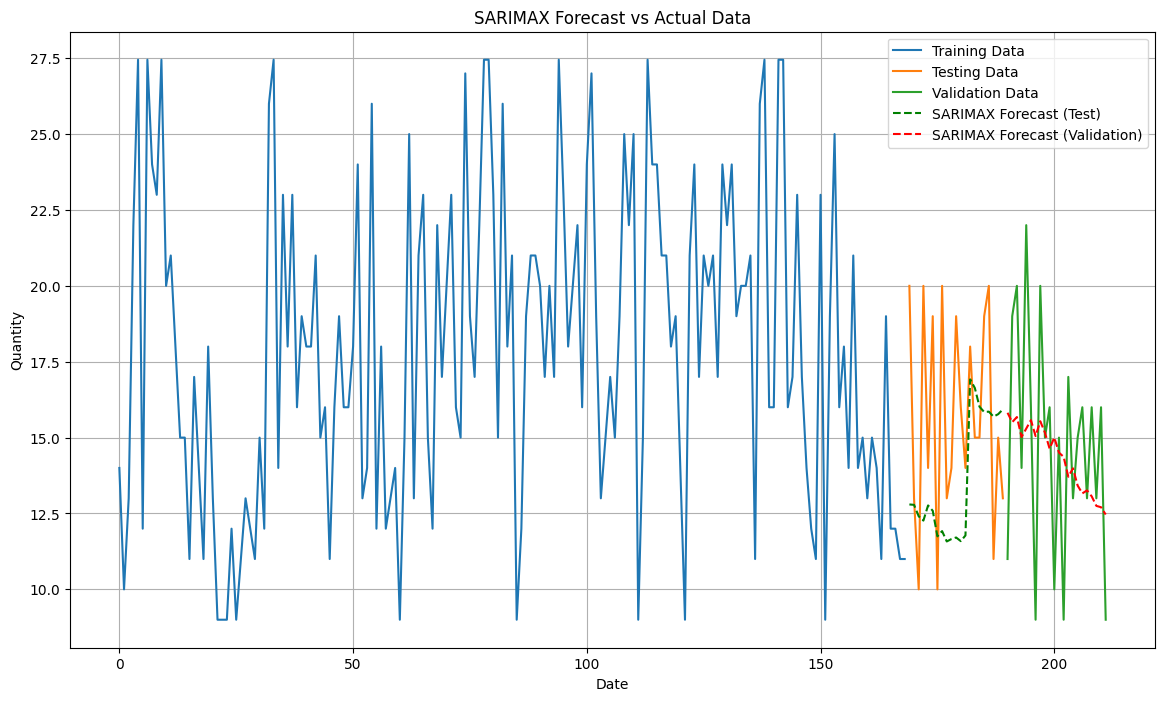

SARIMAX Model - Test Data: RMSE: 4.235821468453355, MAE: 3.4357664630732394, MAPE: 21.033529363601726
SARIMAX Model - Validation Data: RMSE: 3.4814450288664314, MAE: 2.8447542125311536, MAPE: 21.495270465810297


In [52]:
# Define the error metrics for all models
data = {
    'Model': [
        'AR', 'MA', 'ARIMA', 'Auto ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Linear Reg.'
    ],
    'RMSE': [
        4.6960, 4.7216, 4.4915, 4.4912, 4.1049, 3.4802, 3.4814, 3.4800
    ],
    'MAE': [
        3.9714, 3.9731, 3.7633, 3.7629, 3.4409, 2.8253, 2.8448, 2.8251
    ],
    'MAPE': [
        33.3425, 33.4756, 30.7831, 30.7796, 22.6994, 21.5401, 21.4953, 21.5400
    ],
    'R²': [
        0.8324, 0.8318, 0.8419, 0.8420, 0.9931, 0.9911, 0.9924, 0.0630
    ],
    'Adjusted R²': [
        0.8240, 0.8233, 0.8340, 0.8341, 0.9927, 0.9844, 0.9868, -0.7887
    ]
    }
    # Create a DataFrame
df = pd.DataFrame(data)

# Separate the data into two DataFrames: one for test metrics and one for validation metrics
validation_metrics = df[['Model', 'RMSE', 'MAE', 'MAPE', 'R²', 'Adjusted R²']]
# Display the Validation Data Metrics
print("\nValidation Data Values:")
display(validation_metrics.set_index('Model'))

# Define the error metrics for all models
data = {
    'Model': [
        'AR', 'MA', 'ARIMA', 'Auto ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Linear Reg.'
    ],
    'RMSE': [
        4.0537, 4.0814, 3.6846, 3.6843, 4.4374, 4.2130, 4.2358, 4.2124
    ],
    'MAE': [
        3.4664, 3.4767, 3.2806, 3.2804, 3.6185, 3.4335, 3.4358, 3.4331
    ],
    'MAPE': [
        26.2613, 26.4425, 23.7110, 23.7091, 21.2171, 21.1875, 21.0335, 21.1900
    ],
    'R²': [
        -0.4942, -0.5146, -0.2344, -0.2343, -0.7904, -0.6139, -0.6314, -0.6134
    ],
    'Adjusted R²': [
        -0.5728, -0.5944, -0.2994, -0.2992, -0.8846, -1.9344, -1.9663, -2.2269
    ],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Separate the data into two DataFrames: one for test metrics and one for validation metrics
test_metrics = df[['Model', 'RMSE', 'MAE', 'MAPE', 'R²', 'Adjusted R²']]

# Display the Test Data Metrics
print("Test Data Values:")
display(test_metrics.set_index('Model'))

# Define a function to plot the SARIMAX forecast
def plot_sarimax_forecast(train_data, test_data, validation_data, forecast_test, forecast_validation):
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train_data.index, train_data, label='Training Data')

    # Plot testing data
    plt.plot(test_data.index, test_data, label='Testing Data')

    # Plot validation data
    plt.plot(validation_data.index, validation_data, label='Validation Data')

    # Plot SARIMAX forecast for testing data
    plt.plot(test_data.index, forecast_test, linestyle='--', color='g', label='SARIMAX Forecast (Test)')

    # Plot SARIMAX forecast for validation data
    plt.plot(validation_data.index, forecast_validation, linestyle='--', color='r', label='SARIMAX Forecast (Validation)')

    plt.title('SARIMAX Forecast vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot SARIMAX forecast
plot_sarimax_forecast(train_target, test_target, validation_target, sarimax_forecast_test, sarimax_forecast_validation)
# Print the metrics
print(f"SARIMAX Model - Test Data: RMSE: {sarimax_rmse_test}, MAE: {sarimax_mae_test}, MAPE: {sarimax_mape_test}")
print(f"SARIMAX Model - Validation Data: RMSE: {sarimax_rmse_validation}, MAE: {sarimax_mae_validation}, MAPE: {sarimax_mape_validation}")

# **Conclusion:**
*   Based on the performance metrics, the **SARIMAX** model can be considered the best overall due to its strong performance across all metrics on both the test and validation datasets.
*   The **SARIMAX** model offers a good balance between predictive accuracy and robustness, making it the most reliable choice for forecasting 'Quantity' in the dataset.



**Variables considered:**

1.Clicks

2.Impressions

3.Day

4.Year

5.Month_December

6.Month_February

7.Month_January

8.Month_March

9.Month_May